In [4]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import pickle

import time

from RHlib import calc_v_lc, calc_line_width, lc_find, calc_line_width, I_min_find

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
import tensorflow.keras.backend as K
print(tf.__version__)


from scipy.io import readsav
from scipy import interpolate
from scipy.signal import correlate
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) 

#TURBO CHARGE YOUR PYTHON
import multiprocessing
from joblib import Parallel, delayed


2.1.0


In [5]:
import matplotlib as m
fig_size = (8,6)
font = 'Helvetica'
params = {'backend': 'tkagg',
          'axes.labelsize': 9,
          'axes.titlesize': 9,
          'font.size': 8,
          'legend.fontsize': 9,
          'font.family': 'sans-serif',
          'font.sans-serif': font,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'figure.dpi': 80,
          'lines.linewidth': 1.0,
          'axes.linewidth':1.0,
          'image.interpolation'  : 'nearest',
          'xtick.major.size'     : 5,      # major tick size in points
          'xtick.minor.size'     : 3.5,      # minor tick size in points
          'xtick.major.width'    : 0.5,    # major tick width in points
          'xtick.minor.width'    : 0.3,    # minor tick width in points
          'axes.spines.top': False,
          'axes.spines.right':False,
          'xtick.top': False,
          'ytick.right': False,
          'axes.formatter.useoffset': False
}
m.rcParams.update(params)
m.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

m.rcParams['mathtext.fontset'] = 'custom'
m.rcParams['mathtext.rm'] = font
m.rcParams['mathtext.it'] = font+':italic'
m.rcParams['mathtext.bf'] = font+':bold'
m.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [42]:
def build_conv_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  model = keras.Sequential([
    layers.Conv1D(30, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(20, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(15, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(40,activation=tf.nn.relu),
    layers.Dense(40,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


def build_conv_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  model = keras.Sequential([
    layers.Conv1D(20, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(10, (3,),
        activation='relu'),
    layers.Conv1D(10, (4,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(20,activation=tf.nn.relu),
    layers.Dense(20,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 5
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Conv1D(5, (3,), activation='relu')(y1)
    #y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(10, (3,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)

    y = layers.Conv1D(15, (3,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    #y = layers.Dense(20,activation='relu')(y)
    #y = layers.UpSampling1D()(y)
    y = layers.Conv1D(15,(3,), activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(10,(3,), activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(5,(3,), activation='relu')(y)
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd,activation=tf.nn.relu)(y)
    y2 = layers.Add()([y,y1[:,:,0]])
    #y = layers.Dense(40,activation=tf.nn.relu)(y2)

    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    x = layers.Dense(waveNumd,activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

def build_conv_model2():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 3
    waveNumd  = dl
    y1 = layers.Input(shape=[dl,1])
    
    y = layers.Conv1D(5, (kSzConv1D, ))(y1)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.MaxPooling1D(2)(y)
    
    y = layers.Conv1D(10, (kSzConv1D, ))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.MaxPooling1D(2)(y)
    
    y = layers.Conv1D(20, (kSzConv1D, ))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.MaxPooling1D(2)(y)
    
    #y = layers.Dense(dl,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    
    y = layers.Conv1D(20, (kSzConv1D, ))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    
    y = layers.Conv1D(10, (kSzConv1D, ))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.UpSampling1D()(y)
    
    y = layers.Conv1D(5, (kSzConv1D, ))(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    
    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd, activation=tf.nn.relu)(y)
    y2 = layers.Add()([y, y1[:,  :, 0]])
    y = layers.Dense(dl, activation=tf.nn.relu)(y2)

    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    
    x = layers.Dense(dl, activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=1.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss, optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


def build_dense_model():
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Flatten()(y1)
    y = layers.Dense(128,activation='relu')(y)
    #y = layers.Dense(256,activation='relu')(y)
    y = layers.Dense(128,activation='relu')(y)
    #y = layers.Dropout(0.2)(y)
    y = layers.Dense(128,activation='relu')(y)
    y = layers.Dense(128,activation='relu')(y)
    y = layers.Dense(256,activation='relu')(y)
    #y = layers.Flatten()(y)
    y = layers.Dense(waveNumd)(y)
    y = layers.Add()([y,y1[:,:,0]])
    x = layers.Dense(waveNumd,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss=customLoss,
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model 

def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum

def customLoss(yTrue,yPred):
    weights = K.constant(weights_8542_30p)
    return K.mean(K.square(yTrue-yPred)*weights)

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances


def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec
    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250)
    plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='FP1')
    plt.plot(wavescale,profile_FP2,'b.--',label='FP2')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.show()
    
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp

def Gaussian(x,mu,sigma):
    
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)
    
def produce_FP_transmission_peak(Type,dlambda,Dlambda,):
    
    return filterProfile

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec
    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250)
    plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='FP1')
    plt.plot(wavescale,profile_FP2,'b.--',label='FP2')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.show()
    
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp

def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)
    
def produce_FP_transmission_peak(dlambda,lambda_0,Nlambda,FPnum,wavelength):
    wave_I = np.linspace((lambda_0-dlambda*Nlambda/2),(lambda_0+dlambda*Nlambda/2),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    if wavelength == 6563:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_6563']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_6563'] 
    if wavelength == 8542:
        if FPnum == 1:
            t    = ab['ibis_fp1_profile_8542']
        if FPnum == 2:
            t    = ab['ibis_fp2_profile_8542']
    filterProfile = np.interp(wave_I,wave,t)
    return filterProfile

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

In [12]:
print(waveNumd)
model = build_conv_model2()
model.summary()

30
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 28, 5)        20          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 14, 5)        0           conv1d_12[0][0]                  
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 12, 10)       160         max_pooling1d_6[0][0]            
_________________________________________________________________________________________

In [8]:
sizeX = 968
sizeY = 968


cutoutY = 100

waveCut0 = 30
waveCut1 = 60
waveNumd = waveCut1-waveCut0
dl = waveNumd

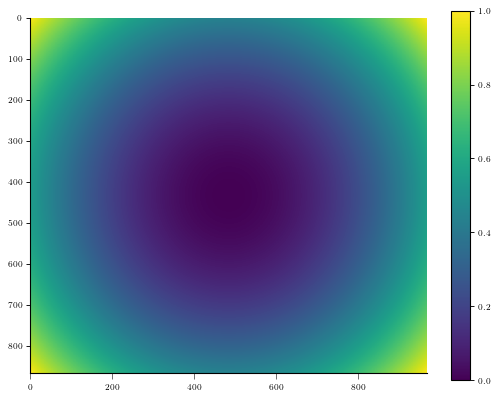

S
Shape of 2Fp spectrum is 89 868 968


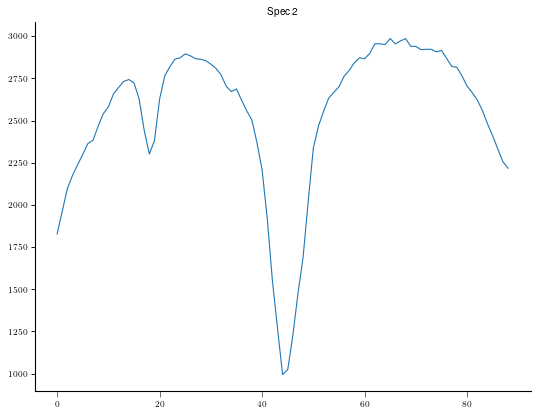

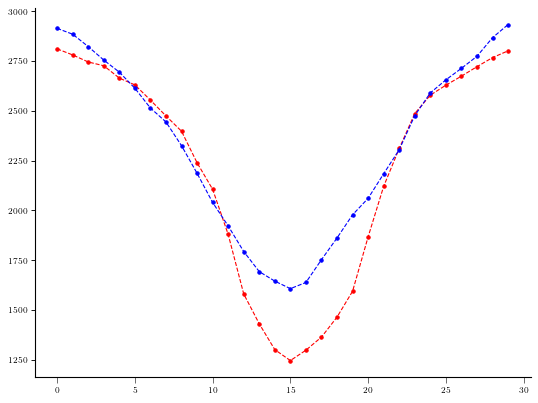

(840224, 30)
Average continuum in training set is 2858.403809
Average continuum in truth set is 2715.388916


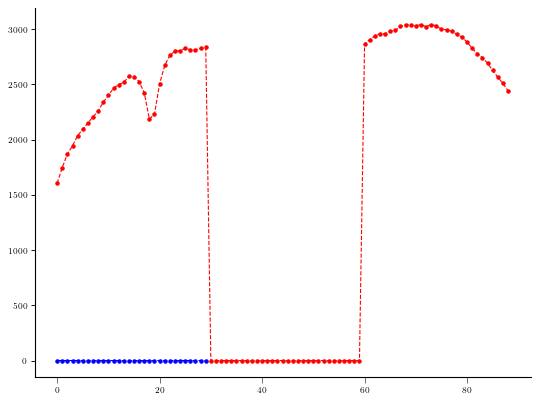

2FP set dimensions are: 840224, 1, 30
2FP set dimensions are:840224,30


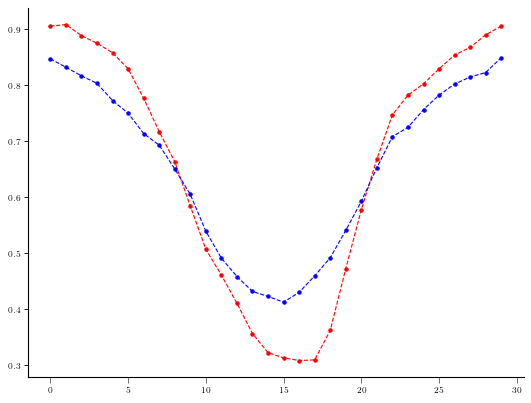

In [9]:
indices = radial_dist(sizeX-cutoutY,sizeY)

indices = indices / max(indices.flatten())
        
im1 = plt.imshow(np.reshape(indices,(sizeX-cutoutY, sizeY)))
plt.colorbar(im1)
plt.show() 

spec1 = (load_spectral_profiles('', 'even_ca_1fp.fits'))[:, cutoutY:, ]
print('S')
waveNum  = (spec1.shape)[0]
spec1 = np.reshape(spec1, (waveNum, (sizeX-cutoutY)*sizeY))
spec1 = np.swapaxes(spec1, 0, 1)

spec2 = (load_spectral_profiles('', 'even_ca_2fp.fits'))[:, cutoutY:, :]
print('Shape of 2Fp spectrum is %d %d %d'%spec2.shape)
plt.plot(spec2[:, 20, 20])
plt.title('Spec 2')
plt.show()
spec2 = np.reshape(spec2,(waveNum,(sizeX-cutoutY)*sizeY))
spec2 = np.swapaxes(spec2,0,1)
train_set1 = spec1[:,waveCut0:waveCut1]
truth_set1 = spec2[:,waveCut0:waveCut1]
plt.plot(truth_set1[200000,:],'r.--')
plt.plot(train_set1[200000,:],'b.--')
plt.show()

print(train_set1.shape)
cont_train = np.mean((train_set1[:,3]+train_set1[:,-3]))/2
cont_truth = np.mean((truth_set1[:,3]+truth_set1[:,-3]))/2
print('Average continuum in training set is %f'%cont_train)
print('Average continuum in truth set is %f'%cont_truth)


# for ii in range(train_set1.shape[0]):
#     cont_12     =  (train_set1[ii,2]+train_set1[ii,-2])
#     if np.isnan(cont_12) == True:
#         print(np.isnan(cont_12))
#     #print(cont_12)
#     train_set1[ii,:] = train_set1[ii,:] / cont_12
# 
# for ii in range(truth_set1.shape[0]):
#     cont_12     =  (truth_set1[ii,2]+truth_set1[ii,-2])
#     if np.isnan(cont_12) == True:
#                 print(np.isnan(cont_12))
#     truth_set1[ii,:] = truth_set1[ii,:] / cont_12


for ii in range(train_set1.shape[0]):
    train_set1[ii, :] = train_set1[ii, :] / (1.2*cont_train)
    truth_set1[ii, :] = truth_set1[ii, :] / (1.2*cont_truth)
   
plt.plot(spec2[200000,:],'r.--')
plt.plot(train_set1[200000,:],'b.--')
plt.show()


train_set = np.zeros(((sizeX - cutoutY) * sizeY, 1, (waveNumd)))
truth_set = np.zeros(((sizeX - cutoutY) * sizeY, (waveNumd)))
print('2FP set dimensions are: %d, %d, %d'%train_set.shape)
train_set[:,0,0:(waveNumd)] = train_set1
#train_set[:,0,(waveNumd)]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set, 1, 2))
print('2FP set dimensions are:%d,%d'%truth_set.shape)
#truth_set = (np.swapaxes(truth_set,0,1))
#print(truth_set.shape)


plt.plot(truth_set[20000, :], 'r.--')
plt.plot(train_set[20000, :], 'b.--')
plt.show()

In [15]:
EPOCHS = 100
skipP = 2
startP = 2 
endP   = -2
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model.optimizer = tf.keras.optimizers.Adam(lr=0.2, beta_1=.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model.optimizer = tf.keras.optimizers.SGD(lr=1e-7, nesterov=True)
    
##print(train_set.shape)
##im2 = np.reshape(train_set,(868,968,waveNumd))
##plt.imshow(im2[200:,:,19])
##plt.show()
##print(truth_set.shape)
##im2 = np.reshape(truth_set,(868,968,waveNumd))
##plt.imshow(im2[200:,:,19])
##plt.show()
history = model.fit((train_set)[startP:endP:skipP,:,:], truth_set[startP:endP:skipP,:],
                    epochs=EPOCHS,validation_split=0.15 , verbose=1)

Train on 357093 samples, validate on 63017 samples
Epoch 1/100
357093/357093 [==============================] - 64s 178us/sample - loss: 0.0016 - mean_absolute_error: 0.0443 - mean_squared_error: 0.0034 - val_loss: 0.0016 - val_mean_absolute_error: 0.0450 - val_mean_squared_error: 0.0035
Epoch 2/100
357093/357093 [==============================] - 62s 175us/sample - loss: 0.0015 - mean_absolute_error: 0.0435 - mean_squared_error: 0.0033 - val_loss: 0.0016 - val_mean_absolute_error: 0.0443 - val_mean_squared_error: 0.0034
Epoch 3/100
357093/357093 [==============================] - 64s 179us/sample - loss: 0.0015 - mean_absolute_error: 0.0430 - mean_squared_error: 0.0032 - val_loss: 0.0016 - val_mean_absolute_error: 0.0439 - val_mean_squared_error: 0.0033
Epoch 4/100
357093/357093 [==============================] - 62s 172us/sample - loss: 0.0015 - mean_absolute_error: 0.0427 - mean_squared_error: 0.0032 - val_loss: 0.0016 - val_mean_absolute_error: 0.0436 - val_mean_squared_error: 0.00

357093/357093 [==============================] - 31s 87us/sample - loss: 0.0014 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0030 - val_loss: 0.0015 - val_mean_absolute_error: 0.0422 - val_mean_squared_error: 0.0031
Epoch 70/100
357093/357093 [==============================] - 30s 84us/sample - loss: 0.0014 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0030 - val_loss: 0.0015 - val_mean_absolute_error: 0.0421 - val_mean_squared_error: 0.0031
Epoch 71/100
357093/357093 [==============================] - 30s 84us/sample - loss: 0.0014 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0030 - val_loss: 0.0015 - val_mean_absolute_error: 0.0421 - val_mean_squared_error: 0.0031
Epoch 72/100
357093/357093 [==============================] - 30s 83us/sample - loss: 0.0014 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0030 - val_loss: 0.0015 - val_mean_absolute_error: 0.0421 - val_mean_squared_error: 0.0031
Epoch 73/100
357093/357093 [==============================] -

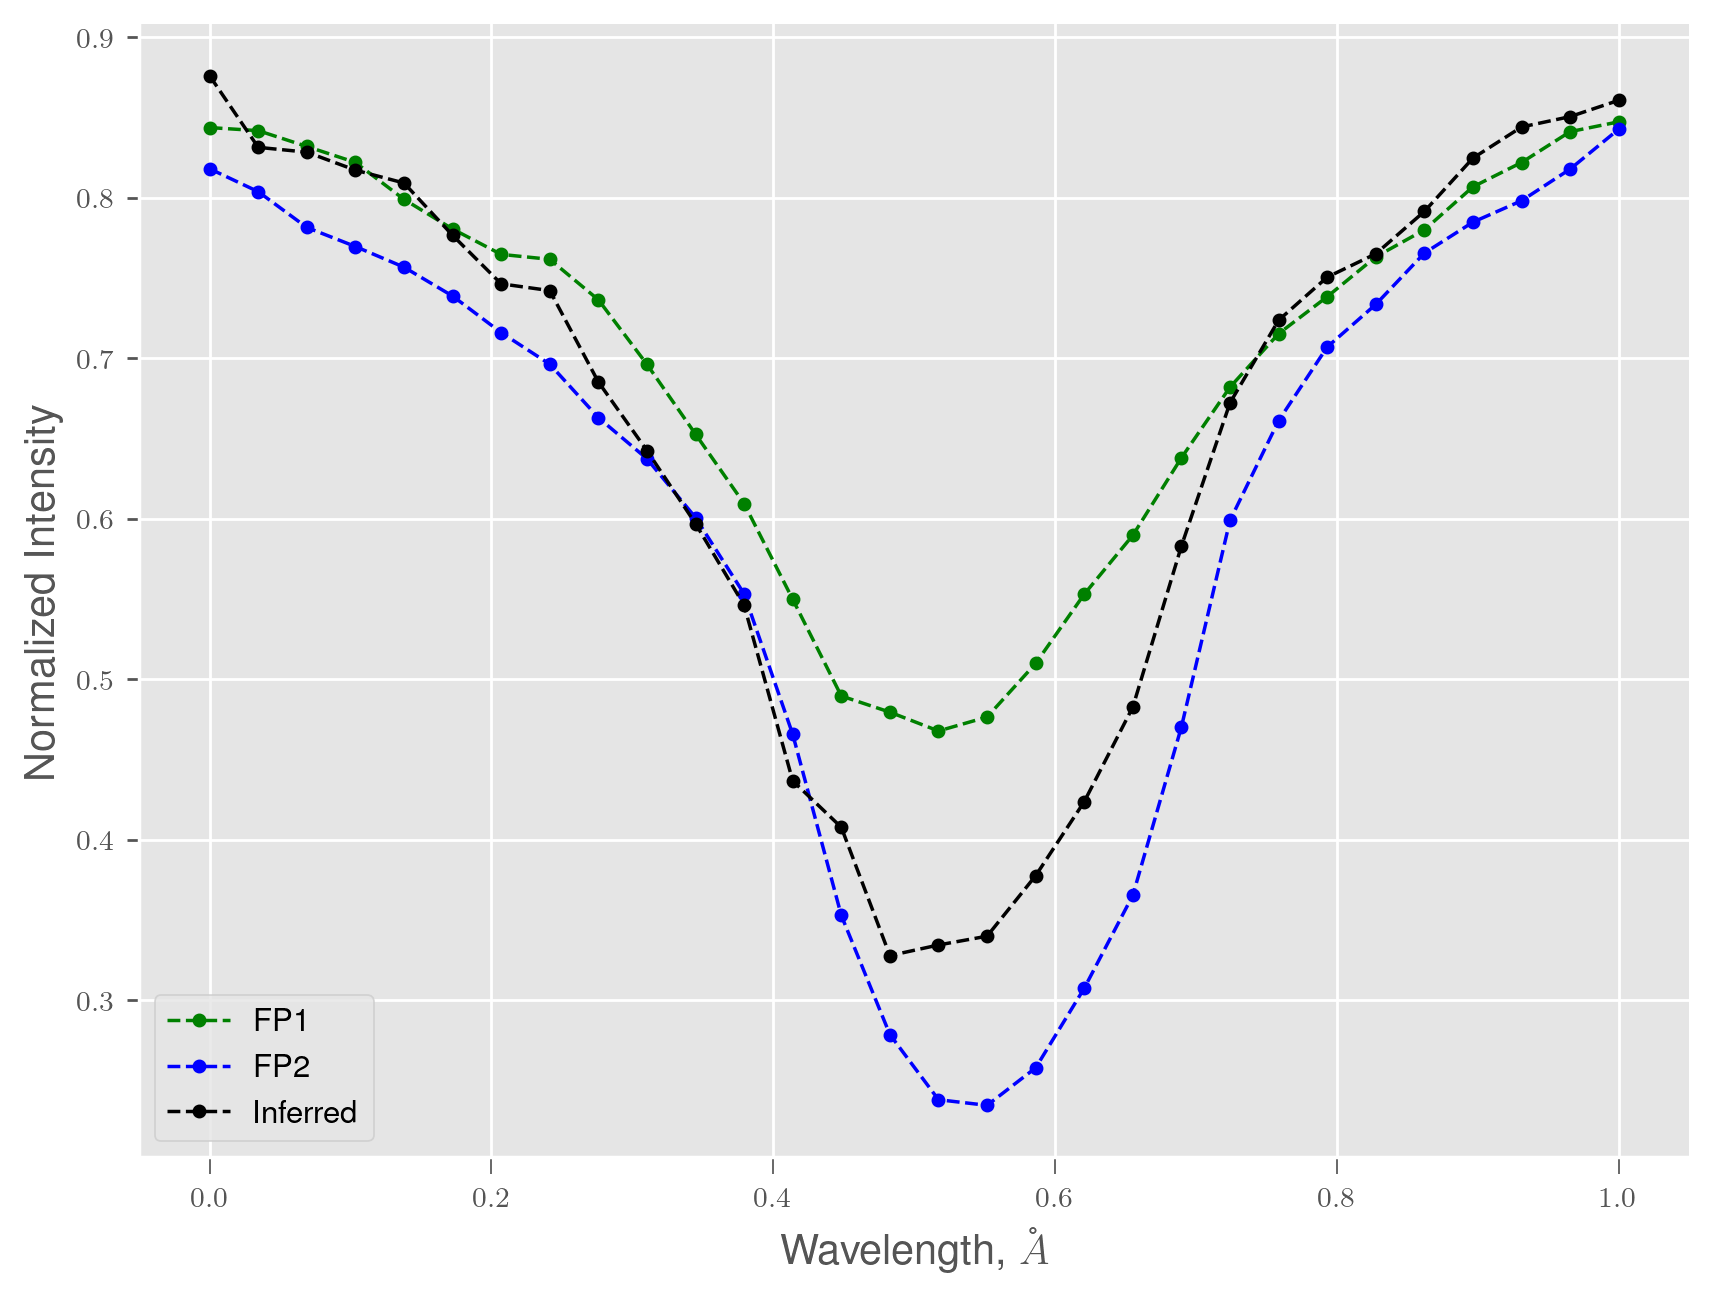

In [20]:
prevNum  = 5000
delta    = 2


#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()

res = model.predict(train_set[prevNum:prevNum+delta,:,:])

wavescale = np.linspace(0,1,num=waveNumd)
plot_spec_profile_comparison(wavescale,train_set[prevNum,:,0],truth_set[prevNum,:],res[0,:])

###### train_set[:,0,50]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set,1,2))
print(train_set.shape)
#truth_set = (np.swapaxes(truth_set,1,2))
print(truth_set.shape)

In [ ]:
im1 = np.reshape(train_set[:,0,0],(968,968))
im = plt.imshow(im1)
plt.colorbar(im)
plt.show()

The elapsed time for 1M Pixel inversion is:   0.00 seconds


NameError: name 'im' is not defined

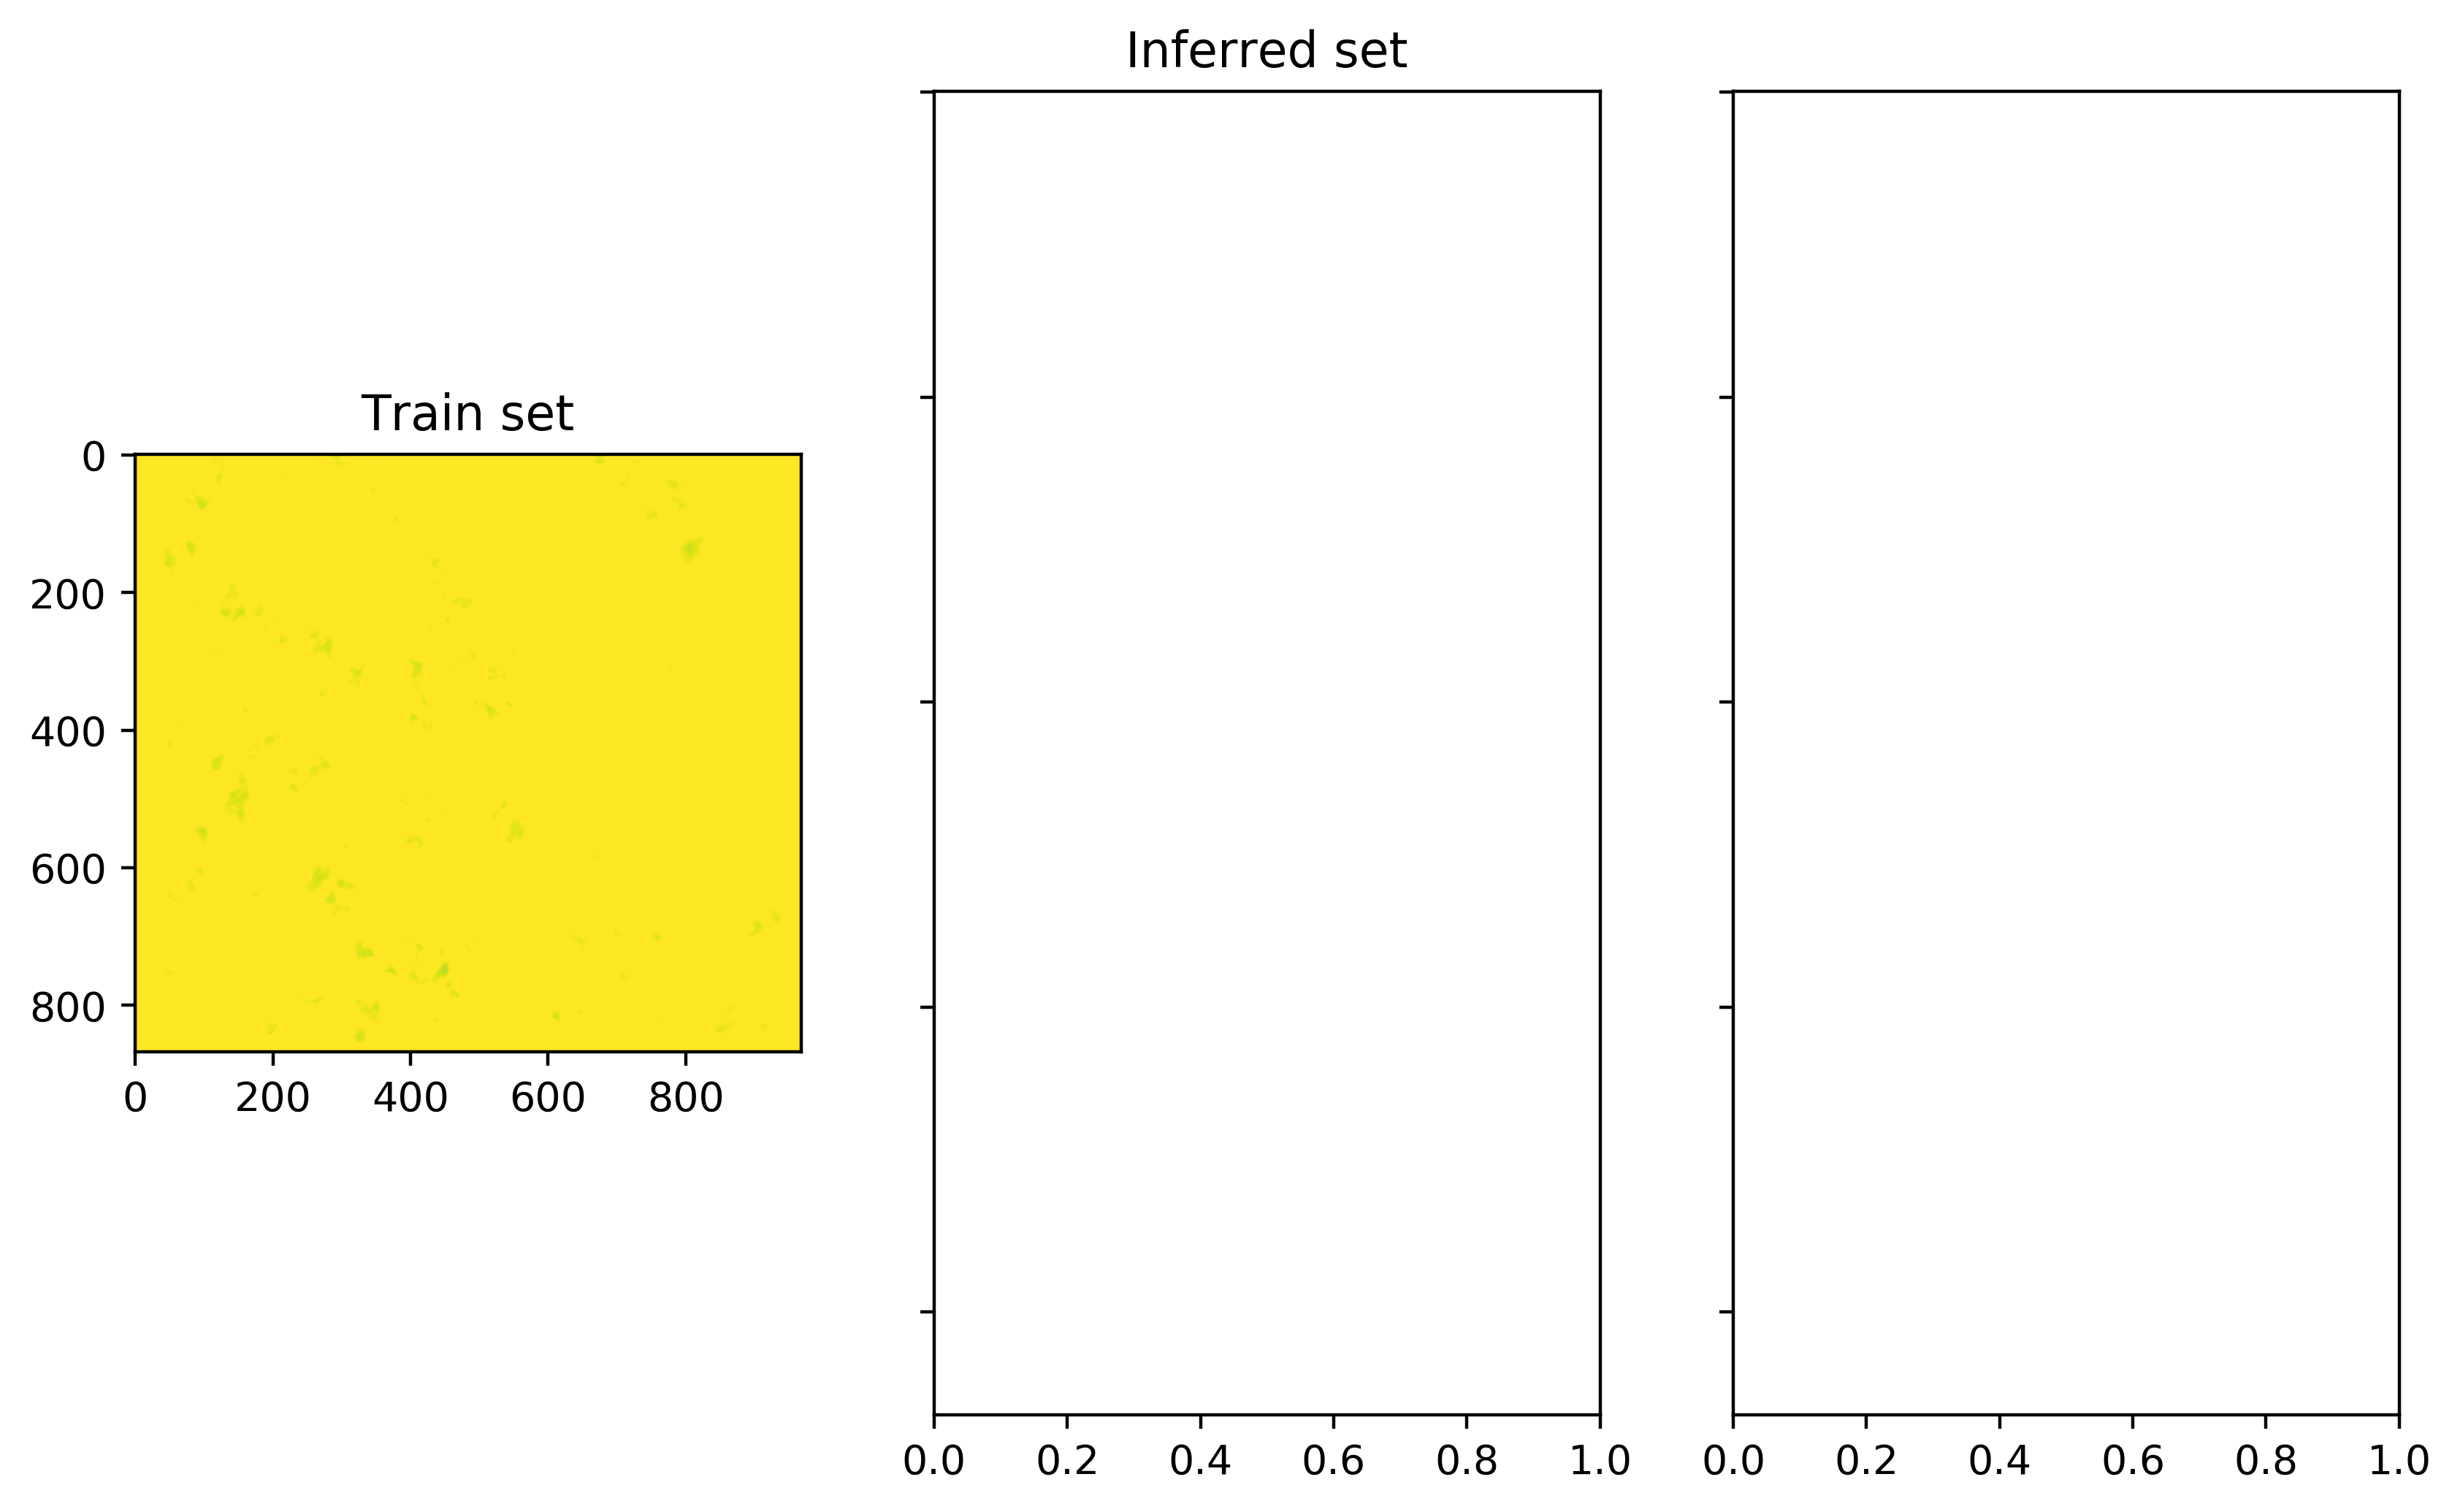

In [8]:
start = time.process_time()
#im = model.predict(train_set[:,:,:])
print("The elapsed time for 1M Pixel inversion is: %6.2f seconds"%(time.process_time() - start))

dim1 = 15
dim2 = 17

vmin_a = 0.01
vmax_a = 0.4


figure, ax = plt.subplots(1,3,sharey=True)
figure.set_dpi(400)
figure.set_size_inches(10,6)
ax[0].set_title('Train set')
im0 = ax[0].imshow(np.reshape(np.mean(train_set[:,dim1:dim2,0],axis=1),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
#divider = make_axes_locatable(ax[0])
#cax0 = divider.append_axes("right", size="5%", pad=0.05)
#figure.colorbar(im0, cax=cax0)
                   
ax[1].set_title('Inferred set')
im1 = ax[1].imshow(np.reshape((np.mean(im[:,dim1:dim2],axis=1)),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
#divider = make_axes_locatable(ax[1])
#cax1 = divider.append_axes("right", size="5%", pad=0.05)
#figure.colorbar(im1, cax=cax1)

ax[2].set_title('Truth set')
im2 = ax[2].imshow(np.reshape(np.mean(truth_set[:,dim1:dim2],axis=1),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
#divider = make_axes_locatable(ax[2])
#cax2 = divider.append_axes("right", size="5%", pad=0.05)
#figure.colorbar(im2, cax=cax2)
plt.show() 

[[0.25357324 0.2559563  0.2550916  ... 0.25338072 0.2599587  0.28296918]
 [0.25151667 0.2561781  0.25301394 ... 0.25278828 0.25898367 0.28204447]
 [0.2505338  0.25588325 0.251787   ... 0.2535449  0.25953498 0.2801066 ]
 ...
 [0.26849306 0.26969892 0.2652846  ... 0.2672784  0.27291656 0.28172302]
 [0.29536462 0.30088642 0.27703372 ... 0.2846953  0.29035878 0.27919888]
 [0.29906228 0.30650473 0.27770975 ... 0.28584844 0.29399756 0.27919957]]


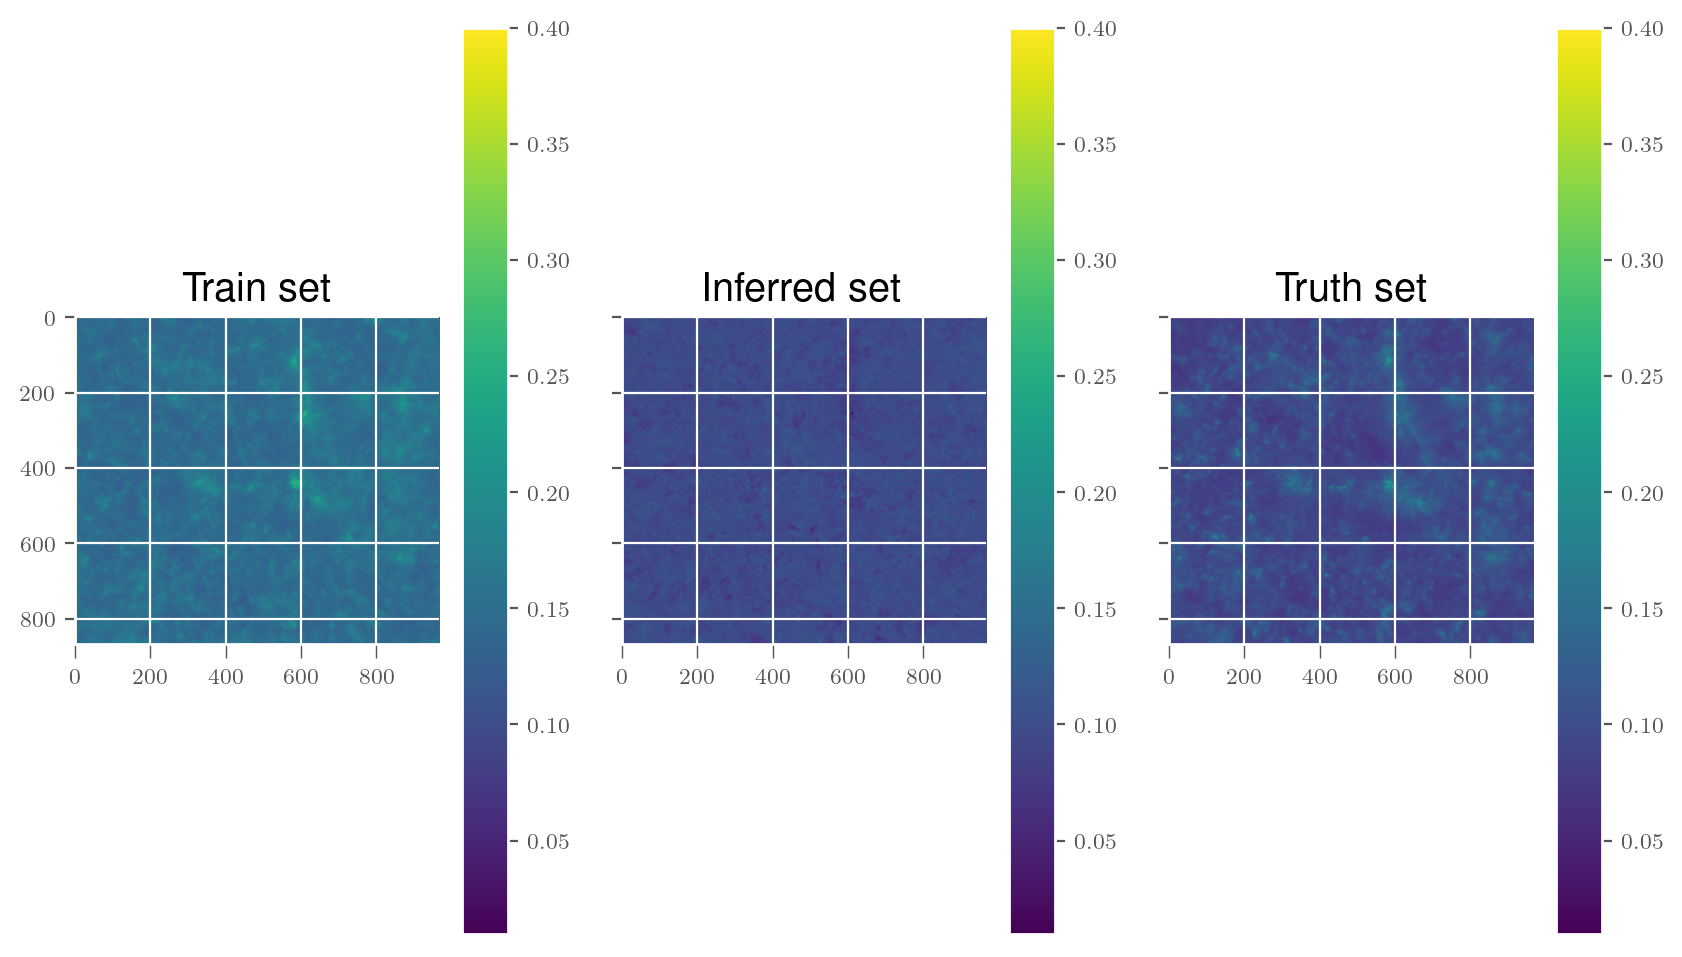

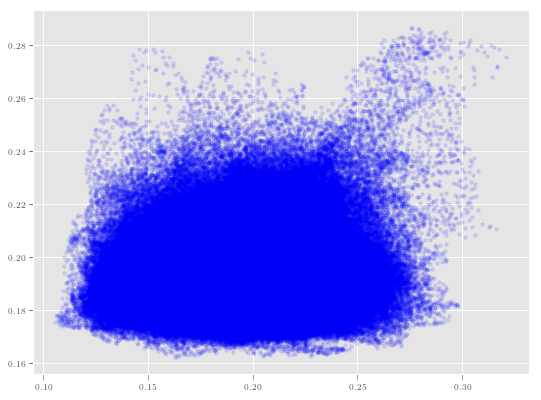

In [363]:
#im = model.predict(train_set[:,:,:])
print(im)

figure, ax = plt.subplots(1,3,sharey=True)
figure.set_dpi(200)
figure.set_size_inches(10,6)
ax[0].set_title('Trai set')
im0 = ax[0].imshow(np.reshape(np.amin(train_set[:,5:-5,0],axis=1),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im0, ax=ax[0])
                   
ax[1].set_title('Inferred set')
im1 = ax[1].imshow(np.reshape((np.amin(im,axis=1)),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im1, ax=ax[1])

ax[2].set_title('Truth set')
im2 = ax[2].imshow(np.reshape(np.amin(truth_set,axis=1),(sizeX-cutoutY,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im2, ax=ax[2])
plt.show() 

plt.plot(truth_set[:,10],im[:,10],'b.',alpha=0.1)
plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([0.06534635, 0.06552591, 0.06570547, ..., 0.24454713, 0.24472669,
       0.24490625]), array([0.02697845, 0.02709664, 0.02721483, ..., 0.14493271, 0.1450509 ,
       0.14516909]))


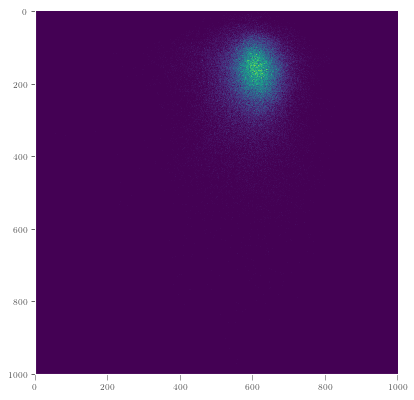

In [365]:
xmin = np.amin(truth_set[:,15])
xmax = np.amax(truth_set[:,15])
ymin = np.amin(im[:,15])
ymax = np.amax(im[:,15])


ab=np.histogram2d(np.amin(truth_set,axis=1),np.amin(im,axis=1),bins=(1000,1000),range=[[xmin,xmax],[ymin,ymax]])



print(ab)
plt.imshow(ab[0])
#plt.imshow(ab[0][0:400,0:400])
plt.grid(b=False)
plt.show()

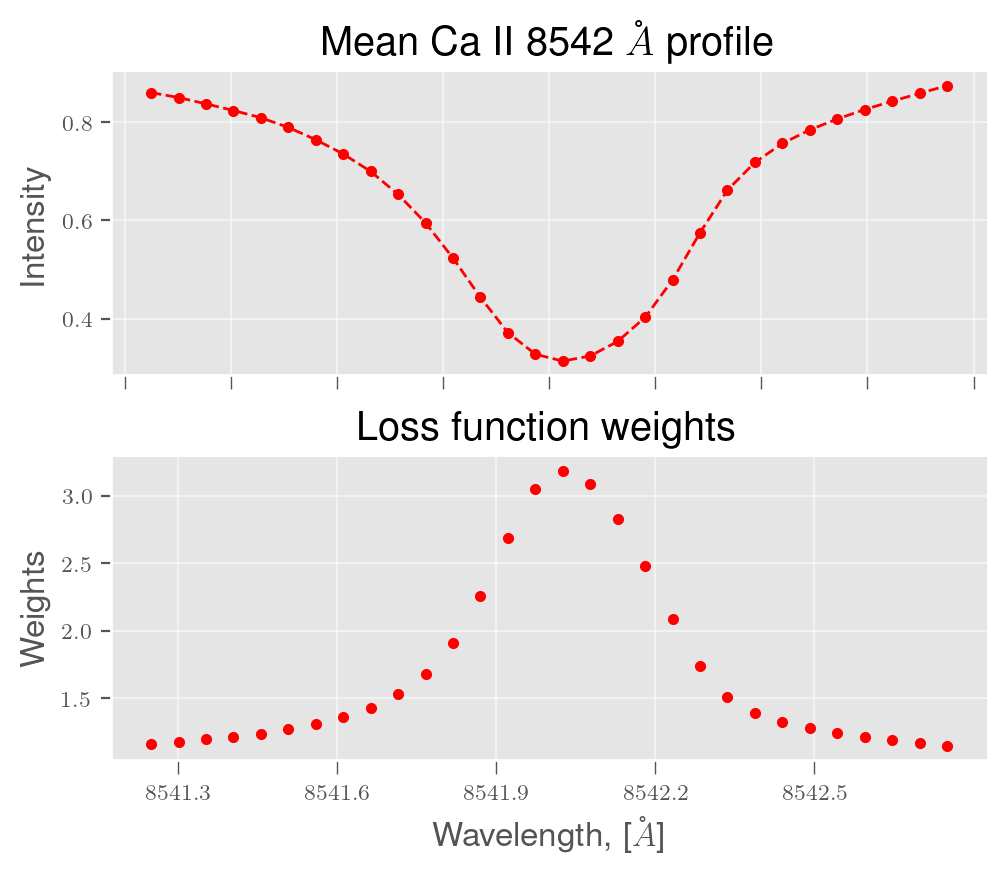

In [34]:
mean_profile_8542 = np.reshape(np.mean(truth_set,axis=0),30)
weights_8542_30p = 1/(1 * mean_profile_8542[:]**1)
caSpectralRes = 0.05
dll = mean_profile_8542.shape[0]
wave = np.linspace(caSpectralRes*dll/(-2),.5*caSpectralRes*dll,num=dll)+8542.0

fig, ax = plt.subplots(2,1)
fig.set_dpi(200)
fig.set_size_inches(5,4)
fig.tight_layout()
for element in ax: 
    element.grid(alpha=0.5)
ax[0].plot(wave,mean_profile_8542,'r.--')
#ax[0].set_ylim(0.08,0.3)
ax[0].set_ylabel('Intensity')
ax[0].set_title('Mean Ca II 8542 $\\AA$ profile')
ax[0].set_xticklabels([])

ax[1].plot(wave,weights_8542_30p,'r.')
#ax[1].set_ylim(0.5,3)
ax[1].xaxis.set_ticks(np.arange(8541.3,8542.8,0.3))
ax[1].set_ylabel('Weights')
ax[1].set_xlabel('Wavelength, [$\\AA$]')
ax[1].set_title('Loss function weights')

plt.savefig('Figures/Loss_function.png',transparent=True,bbox_inches = "tight")

plt.show()

NameError: name 'dim1' is not defined

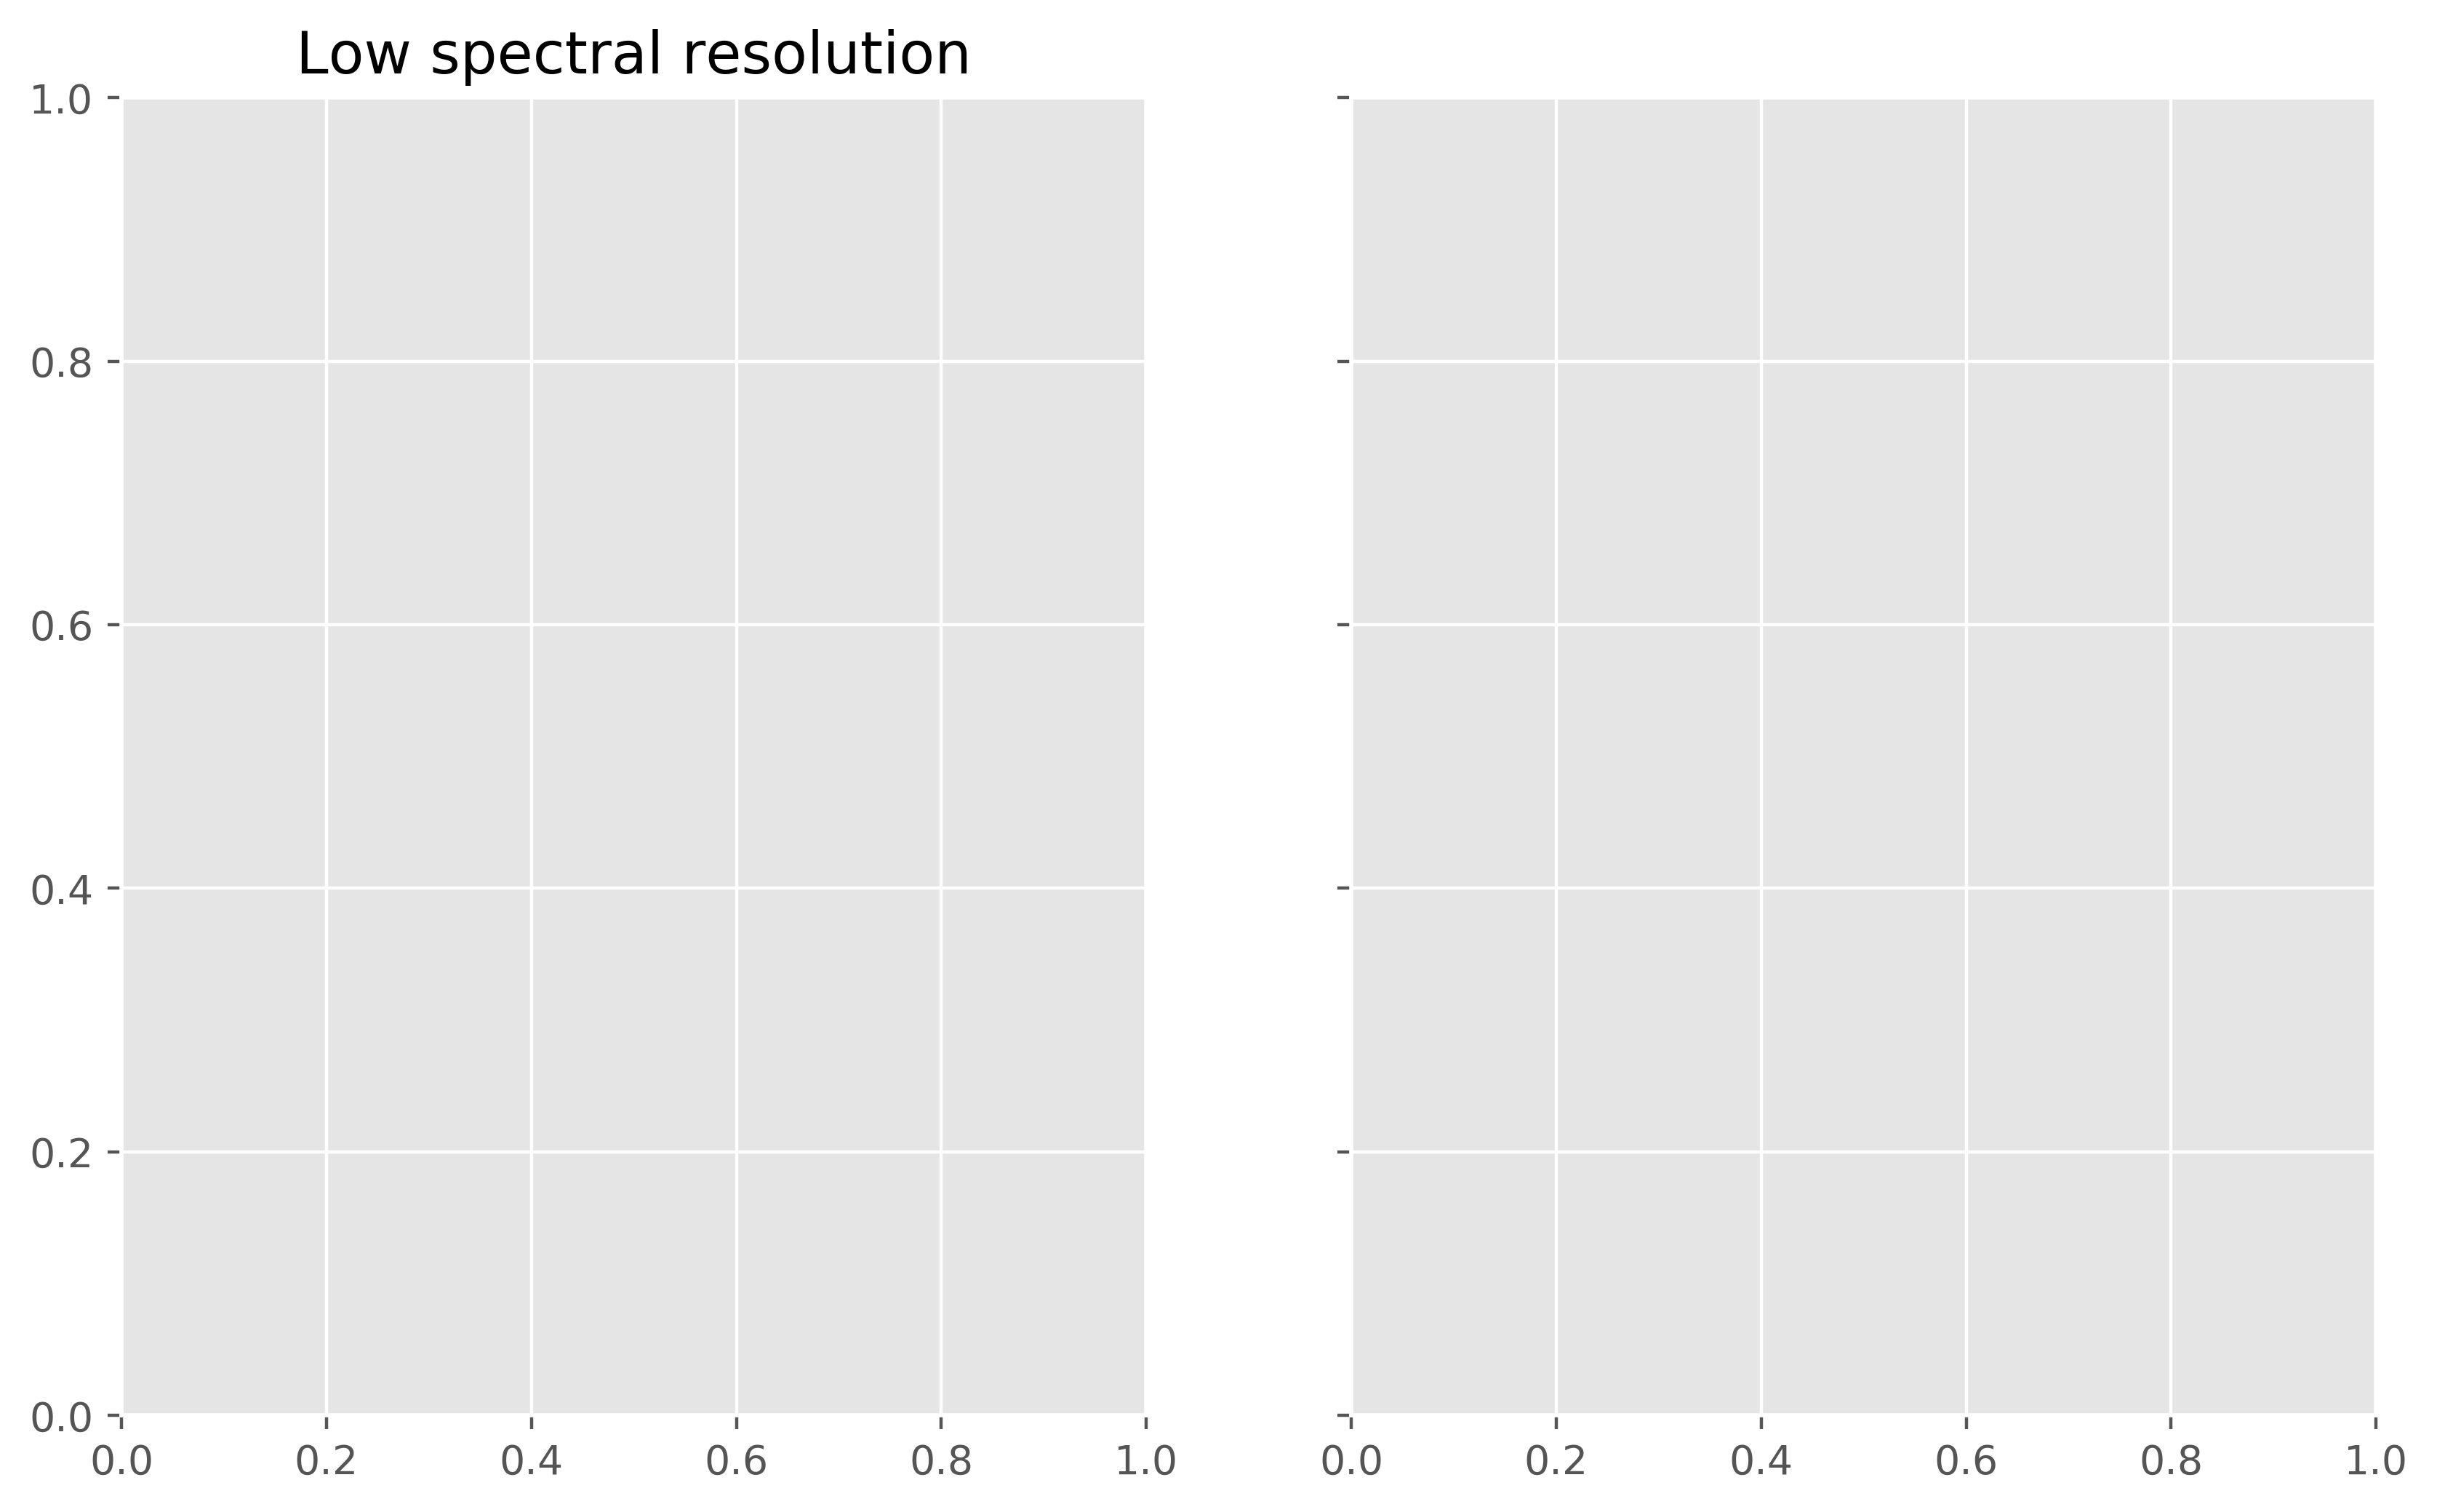

In [331]:
figure, ax = plt.subplots(1,2,sharey=True)
figure.set_dpi(400)
figure.set_size_inches(10,6)

csfont = {'fontname':'Helvetica'}
ax[0].set_title('Low spectral resolution')
for element in ax:
    element.grid(b='false')
im0 = ax[0].imshow(np.reshape(np.mean(train_set[:,dim1:dim2,0],axis=1),(sizeX-cutoutY,sizeY)),cmap='gray')
ax[0].set_ylabel('Solar Y, pixels',**csfont)
ax[0].set_xlabel('Solar X, pixels',**csfont)
#divider = make_axes_locatable(ax[0])
#cax0 = divider.append_axes("right", size="1%", pad=0.05)
#figure.colorbar(im0, cax=cax0)
                   

ax[1].set_title('High spectral resolution')
im2 = ax[1].imshow(np.reshape(np.mean(truth_set[:,dim1:dim2],axis=1),(sizeX-cutoutY,sizeY)),cmap='gray')
#divider = make_axes_locatable(ax[1])
#cax2 = divider.append_axes("right", size="5%", pad=0.05)
#figure.colorbar(im2, cax=cax2)

#ax[1].set_ylabel('Solar Y, pixels',**csfont)
ax[1].set_xlabel('Solar X, pixels',**csfont)
plt.savefig('Figures/IBIS_demo_FP1_inout.png',transparent = True)
plt.show()

## Convolve an IBIS sharp image and then train the network on that and then invert the unsharp image

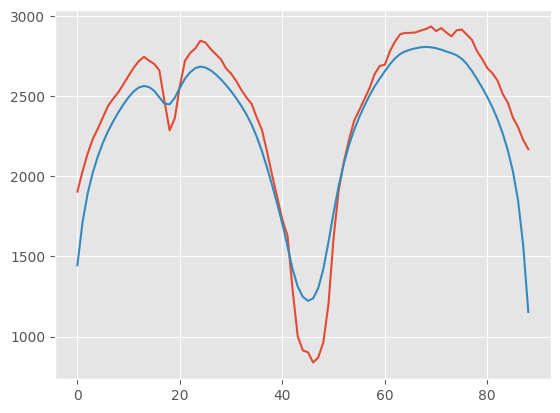

In [115]:
specData = (load_spectral_profiles('','even_ca_2fp.fits'))

specDataNx = specData.shape[1]
specDataNy = specData.shape[2]
specDataNz = specData.shape[0]

specData = np.reshape(specData,(specDataNz,specDataNx*specDataNy))
specData = np.swapaxes(specData,0,1)

TProfile = produce_FP_transmission_peak(0.05,0,specDataNz,2,8542)
TProfile_total = np.sum(TProfile)
TProfile       = TProfile/TProfile_total

specDataConv = np.zeros((specDataNx*specDataNy,specDataNz,1))

for ii in range(specDataNx*specDataNy):
    specDataConv[ii,:,0] = np.convolve(specData[ii,:],TProfile,mode='same')
    
plt.plot(specData[2030,:])
plt.plot(specDataConv[2030,:])
plt.show()

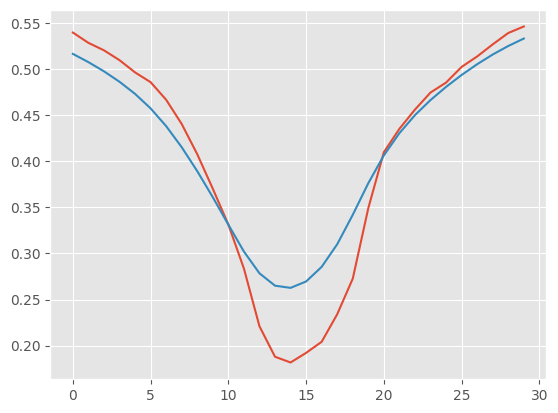

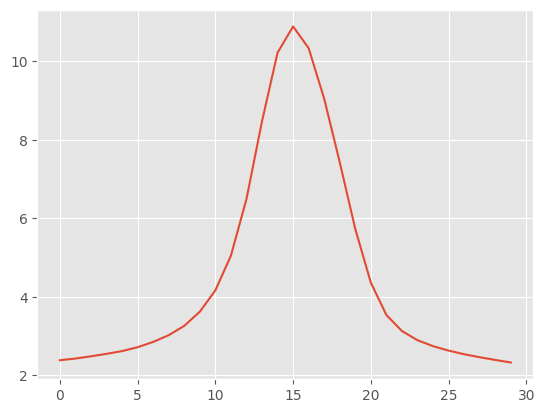

In [158]:
lStart = 30
lEnd   = 60
dl     = lEnd - lStart

specDataM     = specData[:,lStart:lEnd]/5000
specDataMConv = specDataConv[:,lStart:lEnd]/5000

plt.plot(specDataM[2000,:])
plt.plot(specDataMConv[2000,:])
plt.show()

weights = 1/(np.mean(specDataM,axis=0)**1.5)
def customLoss(yTrue,yPred):
    weights1 = K.constant(weights)
    return K.mean(K.square(yTrue-yPred)*weights1)


plt.plot(weights)

## Define a CNN for the IBIS model

In [79]:
model1 = build_conv_model()
model1.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 28, 5)        20          input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_61 (Conv1D)              (None, 26, 10)       160         conv1d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_25 (MaxPooling1D) (None, 13, 10)       0           conv1d_61[0][0]                  
___________________________________________________________________________________________

In [44]:
EPOCHS = 1000
skipP = 2
startP = 2
endP   = -2
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model1.optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=.9,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model1.optimizer = tf.keras.optimizers.SGD(lr=1e-7, nesterov=True)
    
##print(train_set.shape)
##im2 = np.reshape(train_set,(868,968,waveNumd))
##plt.imshow(im2[200:,:,19])
##plt.show()
##print(truth_set.shape)
##im2 = np.reshape(truth_set,(868,968,waveNumd))
##plt.imshow(im2[200:,:,19])
##plt.show()
history = model1.fit(specDataMConv[startP:endP:skipP,:], specDataM[startP:endP:skipP,:],
                    epochs=EPOCHS,validation_split=0.15 , verbose=1)

NameError: name 'model1' is not defined

In [43]:
prevNum  = 31750
delta    = 1

res = model1.predict(specDataMConv[prevNum:(prevNum+delta),:,:])

wavescale = np.linspace(0,1,num=dl)
plot_spec_profile_comparison(wavescale,specDataMConv[prevNum,:,0],specDataM[prevNum,:],res[0,:])

NameError: name 'model1' is not defined

### Choose only not-changing spectral profiles from the IBIS dataset

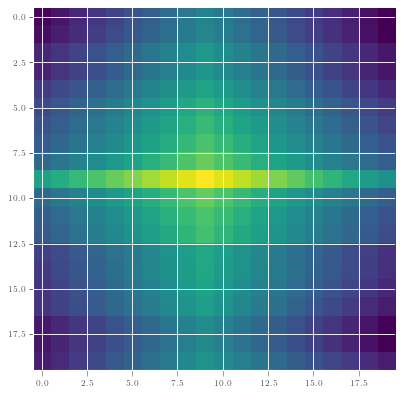

2.0021875287008775


In [34]:
x_size = 968
y_size = 868
dd     = 10

cor_matrix = correlate(np.reshape(truth_set1[:, 14], (x_size, y_size)),
                       np.reshape(train_set1[:, 14], (x_size, y_size)))
plt.imshow(np.log(cor_matrix[(x_size-dd):(x_size+dd), (y_size-dd):(y_size+dd)]))
plt.show()
print(np.argmax(cor_matrix, axis=None)/(x_size-1)/(y_size-1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


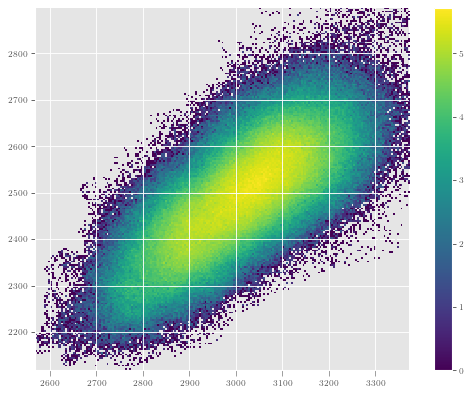

In [102]:
res   = 200
index = -2
xedges = np.linspace(np.amin(spec1[:, index])*1, 
                     np.amax(spec1[:, index])*.9, num = res)
yedges = np.linspace(np.amin(spec2[:, index])*1, 
                     np.amax(spec2[:, index])*.9, num = res)
H, xedges, yedges = np.histogram2d(spec1[:, index], spec2[:, index],
                                   bins=(xedges, yedges))
H = H.T
im1 = plt.imshow(np.log(H), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           interpolation='nearest', origin='low')
plt.colorbar(im1)
plt.show()

In [16]:
# # Calculate percentiles 
# 
data_subset = 1
percentiles_x = np.linspace(0, 100, num=1000)
# 
# min_I_train = np.zeros(train_set1[:, 0].size)
# min_I_truth = np.zeros(train_set1[:, 0].size)
# 
# width_train = np.zeros(train_set1[:, 0].size)
# width_truth = np.zeros(train_set1[:, 0].size)
# 
# vmin_I_train = np.zeros(train_set1[:, 0].size)
# vmin_I_truth = np.zeros(train_set1[:, 0].size)
# 
# waves = np.linspace(0, 29, num=30)
# # 
# # print("Calculate train set velocities")
# vmin_I_train = Parallel(n_jobs=4)(delayed(calc_v_lc)(waves, i, 2, -2, 7) for i in train_set1)
# # print("Calculate truth set velocities")
# vmin_I_truth = Parallel(n_jobs=4)(delayed(calc_v_lc)(waves, i, 2, -2, 7) for i in truth_set1)
# print("Calculate widths -- Train set first")
# widths_train = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, 7, .5) for i in train_set1)
# print("Calculate widths -- Truth set (2/2)")
# widths_truth = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, 7, .5) for i in truth_set1)
# 
# print("Calculate I_min for train set")
# min_I_train = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, 2, -2, 7) for i in train_set1)
# 
# print("Calculate I_min for truth set")
# min_I_truth = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, 2, -2, 7) for i in truth_set1)

# width_train = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, 6, .5) for i in train_set1)
# for i in range(int(train_set1[:, 0].size/data_subset)):
#     if i%(20000) == 0: 
#         print(str(int(i/833000*100*data_subset)) + ' %')
#     vmin_I_train[i] = calc_v_lc(np.linspace(1, 30, num=30), train_set1[i], 2, -2, 7)[0]
#     vmin_I_truth[i] = calc_v_lc(np.linspace(1, 30, num=30), truth_set1[i], 2, -2, 7)[0]
# print('Done with velocities calculation.')

vpercentiles_y_train = np.nanpercentile(vmin_I_train, percentiles_x)
vpercentiles_y_truth = np.nanpercentile(vmin_I_truth, percentiles_x)

Ipercentiles_y_train = np.nanpercentile(min_I_train, percentiles_x)
Ipercentiles_y_truth = np.nanpercentile(min_I_truth, percentiles_x)

wpercentiles_y_train = np.nanpercentile(widths_train, percentiles_x)
wpercentiles_y_truth = np.nanpercentile(widths_truth, percentiles_x)

f_vp_train = interpolate.interp1d(vpercentiles_y_train, percentiles_x, kind='slinear')
f_vp_truth = interpolate.interp1d(vpercentiles_y_truth, percentiles_x, kind='slinear')

f_I_train = interpolate.interp1d(Ipercentiles_y_train, percentiles_x, kind='slinear')
f_I_truth = interpolate.interp1d(Ipercentiles_y_truth, percentiles_x, kind='slinear')

f_w_train = interpolate.interp1d(wpercentiles_y_train, percentiles_x, kind='slinear')
f_w_truth = interpolate.interp1d(wpercentiles_y_truth, percentiles_x, kind='slinear')

In [59]:
truth_set_modified = []
train_set_modified = []

dpercentile_I = 10
dpercentile_w = 10
dv = .2

range_counter = int(train_set1[:, 0].size)

for ii in range(int(range_counter/data_subset)):
    if ii%(40000) == 0: 
        print(str(int(ii/range_counter*100*data_subset))+' %')

    if (np.abs(f_I_train(min_I_train[ii]) - f_I_truth(min_I_truth[ii])) 
        <= dpercentile_I) and (np.abs(f_w_train(widths_train[ii]) - f_w_truth(widths_truth[ii])) 
                               <= dpercentile_w):
        if np.abs(vmin_I_train[ii] 
                  - vmin_I_truth[ii]) < dv:
            train_set_modified.append(train_set[ii, :, :])
            truth_set_modified.append(truth_set1[ii, :])

range_i = len(truth_set_modified)
print(f"The number of classified profiles is:{range_i}")
truth_set_modified
truth_set_modified_ML = np.zeros((range_i, 30))
train_set_modified_ML = np.zeros((range_i, 30, 1))

for ii in range(range_i): 
    truth_set_modified_ML[ii, :] = truth_set_modified[ii]
    train_set_modified_ML[ii, :, :] = train_set_modified[ii] 

0 %
4 %
9 %
14 %
19 %
23 %
28 %
33 %
38 %
42 %
47 %
52 %
57 %
61 %
66 %
71 %
76 %
80 %
85 %
90 %
95 %
99 %
The number of classified profiles is:7860


In [76]:
EPOCHS = 300
skipP = 1
startP = 1 
endP   = -1
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model.optimizer = tf.keras.optimizers.Adam(lr=.1, beta_1=.99,
              beta_2=0.999, epsilon=1e-8, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model.optimizer = tf.keras.optimizers.SGD(lr=1e-1, nesterov=True)

history = model.fit(train_set_modified_ML[startP:endP:skipP,:,:], truth_set_modified_ML[startP:endP:skipP,:],
                    epochs=EPOCHS, validation_split=0.15, verbose=1)

Train on 6679 samples, validate on 1179 samples
Epoch 1/300
6679/6679 [==============================] - 3s 499us/sample - loss: 0.1522 - mean_absolute_error: 0.1944 - mean_squared_error: 0.0863 - val_loss: 0.0204 - val_mean_absolute_error: 0.0946 - val_mean_squared_error: 0.0117
Epoch 2/300
6679/6679 [==============================] - 1s 204us/sample - loss: 0.0101 - mean_absolute_error: 0.0590 - mean_squared_error: 0.0055 - val_loss: 0.0061 - val_mean_absolute_error: 0.0448 - val_mean_squared_error: 0.0034
Epoch 3/300
6679/6679 [==============================] - 1s 207us/sample - loss: 0.0059 - mean_absolute_error: 0.0436 - mean_squared_error: 0.0032 - val_loss: 0.0054 - val_mean_absolute_error: 0.0424 - val_mean_squared_error: 0.0030
Epoch 4/300
6679/6679 [==============================] - 1s 208us/sample - loss: 0.0055 - mean_absolute_error: 0.0421 - mean_squared_error: 0.0030 - val_loss: 0.0051 - val_mean_absolute_error: 0.0407 - val_mean_squared_error: 0.0028
Epoch 5/300
6679/667

Epoch 36/300
6679/6679 [==============================] - 1s 211us/sample - loss: 0.0049 - mean_absolute_error: 0.0402 - mean_squared_error: 0.0027 - val_loss: 0.0047 - val_mean_absolute_error: 0.0392 - val_mean_squared_error: 0.0026
Epoch 37/300
6679/6679 [==============================] - 2s 227us/sample - loss: 0.0049 - mean_absolute_error: 0.0401 - mean_squared_error: 0.0027 - val_loss: 0.0047 - val_mean_absolute_error: 0.0392 - val_mean_squared_error: 0.0026
Epoch 38/300
6679/6679 [==============================] - 1s 213us/sample - loss: 0.0049 - mean_absolute_error: 0.0401 - mean_squared_error: 0.0027 - val_loss: 0.0047 - val_mean_absolute_error: 0.0392 - val_mean_squared_error: 0.0026
Epoch 39/300
6679/6679 [==============================] - 2s 226us/sample - loss: 0.0049 - mean_absolute_error: 0.0400 - mean_squared_error: 0.0027 - val_loss: 0.0046 - val_mean_absolute_error: 0.0391 - val_mean_squared_error: 0.0026
Epoch 40/300
6679/6679 [==============================] - 1s 208

6679/6679 [==============================] - 2s 254us/sample - loss: 0.0046 - mean_absolute_error: 0.0390 - mean_squared_error: 0.0026 - val_loss: 0.0044 - val_mean_absolute_error: 0.0381 - val_mean_squared_error: 0.0025
Epoch 72/300
6679/6679 [==============================] - 2s 250us/sample - loss: 0.0046 - mean_absolute_error: 0.0390 - mean_squared_error: 0.0026 - val_loss: 0.0044 - val_mean_absolute_error: 0.0381 - val_mean_squared_error: 0.0025
Epoch 73/300
6679/6679 [==============================] - 2s 249us/sample - loss: 0.0046 - mean_absolute_error: 0.0390 - mean_squared_error: 0.0026 - val_loss: 0.0044 - val_mean_absolute_error: 0.0381 - val_mean_squared_error: 0.0025
Epoch 74/300
6679/6679 [==============================] - 2s 241us/sample - loss: 0.0046 - mean_absolute_error: 0.0390 - mean_squared_error: 0.0026 - val_loss: 0.0044 - val_mean_absolute_error: 0.0380 - val_mean_squared_error: 0.0025
Epoch 75/300
6679/6679 [==============================] - 2s 238us/sample - l

6679/6679 [==============================] - 2s 247us/sample - loss: 0.0044 - mean_absolute_error: 0.0384 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_absolute_error: 0.0375 - val_mean_squared_error: 0.0024
Epoch 107/300
6679/6679 [==============================] - 2s 246us/sample - loss: 0.0044 - mean_absolute_error: 0.0384 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_absolute_error: 0.0374 - val_mean_squared_error: 0.0024
Epoch 108/300
6679/6679 [==============================] - 2s 251us/sample - loss: 0.0044 - mean_absolute_error: 0.0384 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_absolute_error: 0.0374 - val_mean_squared_error: 0.0024
Epoch 109/300
6679/6679 [==============================] - 2s 254us/sample - loss: 0.0044 - mean_absolute_error: 0.0383 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_absolute_error: 0.0374 - val_mean_squared_error: 0.0024
Epoch 110/300
6679/6679 [==============================] - 2s 250us/sample

Epoch 141/300
6679/6679 [==============================] - 2s 246us/sample - loss: 0.0043 - mean_absolute_error: 0.0379 - mean_squared_error: 0.0024 - val_loss: 0.0041 - val_mean_absolute_error: 0.0370 - val_mean_squared_error: 0.0023
Epoch 142/300
6679/6679 [==============================] - 2s 246us/sample - loss: 0.0043 - mean_absolute_error: 0.0379 - mean_squared_error: 0.0024 - val_loss: 0.0041 - val_mean_absolute_error: 0.0370 - val_mean_squared_error: 0.0023
Epoch 143/300
6679/6679 [==============================] - 2s 247us/sample - loss: 0.0043 - mean_absolute_error: 0.0379 - mean_squared_error: 0.0024 - val_loss: 0.0041 - val_mean_absolute_error: 0.0370 - val_mean_squared_error: 0.0023
Epoch 144/300
6679/6679 [==============================] - 2s 254us/sample - loss: 0.0043 - mean_absolute_error: 0.0379 - mean_squared_error: 0.0024 - val_loss: 0.0041 - val_mean_absolute_error: 0.0369 - val_mean_squared_error: 0.0023
Epoch 145/300
6679/6679 [==============================] - 2

Epoch 176/300
6679/6679 [==============================] - 2s 239us/sample - loss: 0.0042 - mean_absolute_error: 0.0376 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0367 - val_mean_squared_error: 0.0023
Epoch 177/300
6679/6679 [==============================] - 2s 237us/sample - loss: 0.0042 - mean_absolute_error: 0.0376 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0367 - val_mean_squared_error: 0.0023
Epoch 178/300
6679/6679 [==============================] - 2s 232us/sample - loss: 0.0042 - mean_absolute_error: 0.0376 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0366 - val_mean_squared_error: 0.0023
Epoch 179/300
6679/6679 [==============================] - 2s 231us/sample - loss: 0.0042 - mean_absolute_error: 0.0376 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0366 - val_mean_squared_error: 0.0023
Epoch 180/300
6679/6679 [==============================] - 2

Epoch 211/300
6679/6679 [==============================] - 2s 248us/sample - loss: 0.0042 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0364 - val_mean_squared_error: 0.0023
Epoch 212/300
6679/6679 [==============================] - 2s 246us/sample - loss: 0.0042 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0364 - val_mean_squared_error: 0.0023
Epoch 213/300
6679/6679 [==============================] - 2s 250us/sample - loss: 0.0042 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0364 - val_mean_squared_error: 0.0023
Epoch 214/300
6679/6679 [==============================] - 2s 250us/sample - loss: 0.0041 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0024 - val_loss: 0.0040 - val_mean_absolute_error: 0.0364 - val_mean_squared_error: 0.0023
Epoch 215/300
6679/6679 [==============================] - 2

Epoch 246/300
6679/6679 [==============================] - 2s 245us/sample - loss: 0.0041 - mean_absolute_error: 0.0372 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_absolute_error: 0.0362 - val_mean_squared_error: 0.0022
Epoch 247/300
6679/6679 [==============================] - 2s 238us/sample - loss: 0.0041 - mean_absolute_error: 0.0372 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_absolute_error: 0.0362 - val_mean_squared_error: 0.0022
Epoch 248/300
6679/6679 [==============================] - 2s 228us/sample - loss: 0.0041 - mean_absolute_error: 0.0372 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_absolute_error: 0.0362 - val_mean_squared_error: 0.0022
Epoch 249/300
6679/6679 [==============================] - 2s 237us/sample - loss: 0.0041 - mean_absolute_error: 0.0372 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_absolute_error: 0.0362 - val_mean_squared_error: 0.0022
Epoch 250/300
6679/6679 [==============================] - 2

Epoch 281/300
6679/6679 [==============================] - 2s 288us/sample - loss: 0.0041 - mean_absolute_error: 0.0370 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_absolute_error: 0.0360 - val_mean_squared_error: 0.0022
Epoch 282/300
6679/6679 [==============================] - 2s 291us/sample - loss: 0.0040 - mean_absolute_error: 0.0370 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_absolute_error: 0.0360 - val_mean_squared_error: 0.0022
Epoch 283/300
6679/6679 [==============================] - 2s 270us/sample - loss: 0.0040 - mean_absolute_error: 0.0370 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_absolute_error: 0.0360 - val_mean_squared_error: 0.0022
Epoch 284/300
6679/6679 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0370 - mean_squared_error: 0.00 - 2s 268us/sample - loss: 0.0040 - mean_absolute_error: 0.0370 - mean_squared_error: 0.0023 - val_loss: 0.0039 - val_mean_absolute_error: 0.0360 - val_mean_

In [75]:
print(waveNumd)
model = build_conv_model2()
model.summary()

30
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 28, 5)        20          input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 28, 5)        20          conv1d_48[0][0]                  
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 28, 5)        0           batch_normalization_48[0][0]     
_________________________________________________________________________________________

<Figure size 1200x900 with 0 Axes>

RuntimeError: latex was not able to process the following string:
b'Predicted line width[x.05 $\\\\AA$}]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/molnarad/.matplotlib/tex.cache/b5393cefae48ea6b018b8bfc5d9463ed.tex
LaTeX2e <2018-04-01> patch level 5
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./b5393cefae48ea6b018b8bfc5d9463ed.aux)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/local/texlive/2016/texmf-dist/tex/latex/psnfss/ot1phv.fd)

LaTeX Warning: Command \r invalid in math mode on input line 14.

! Too many }'s.
l.14 ...ffamily Predicted line width[x.05 $\AA$}]}
                                                  
No pages of output.
Transcript written on b5393cefae48ea6b018b8bfc5d9463ed.log.




<Figure size 1200x900 with 1 Axes>

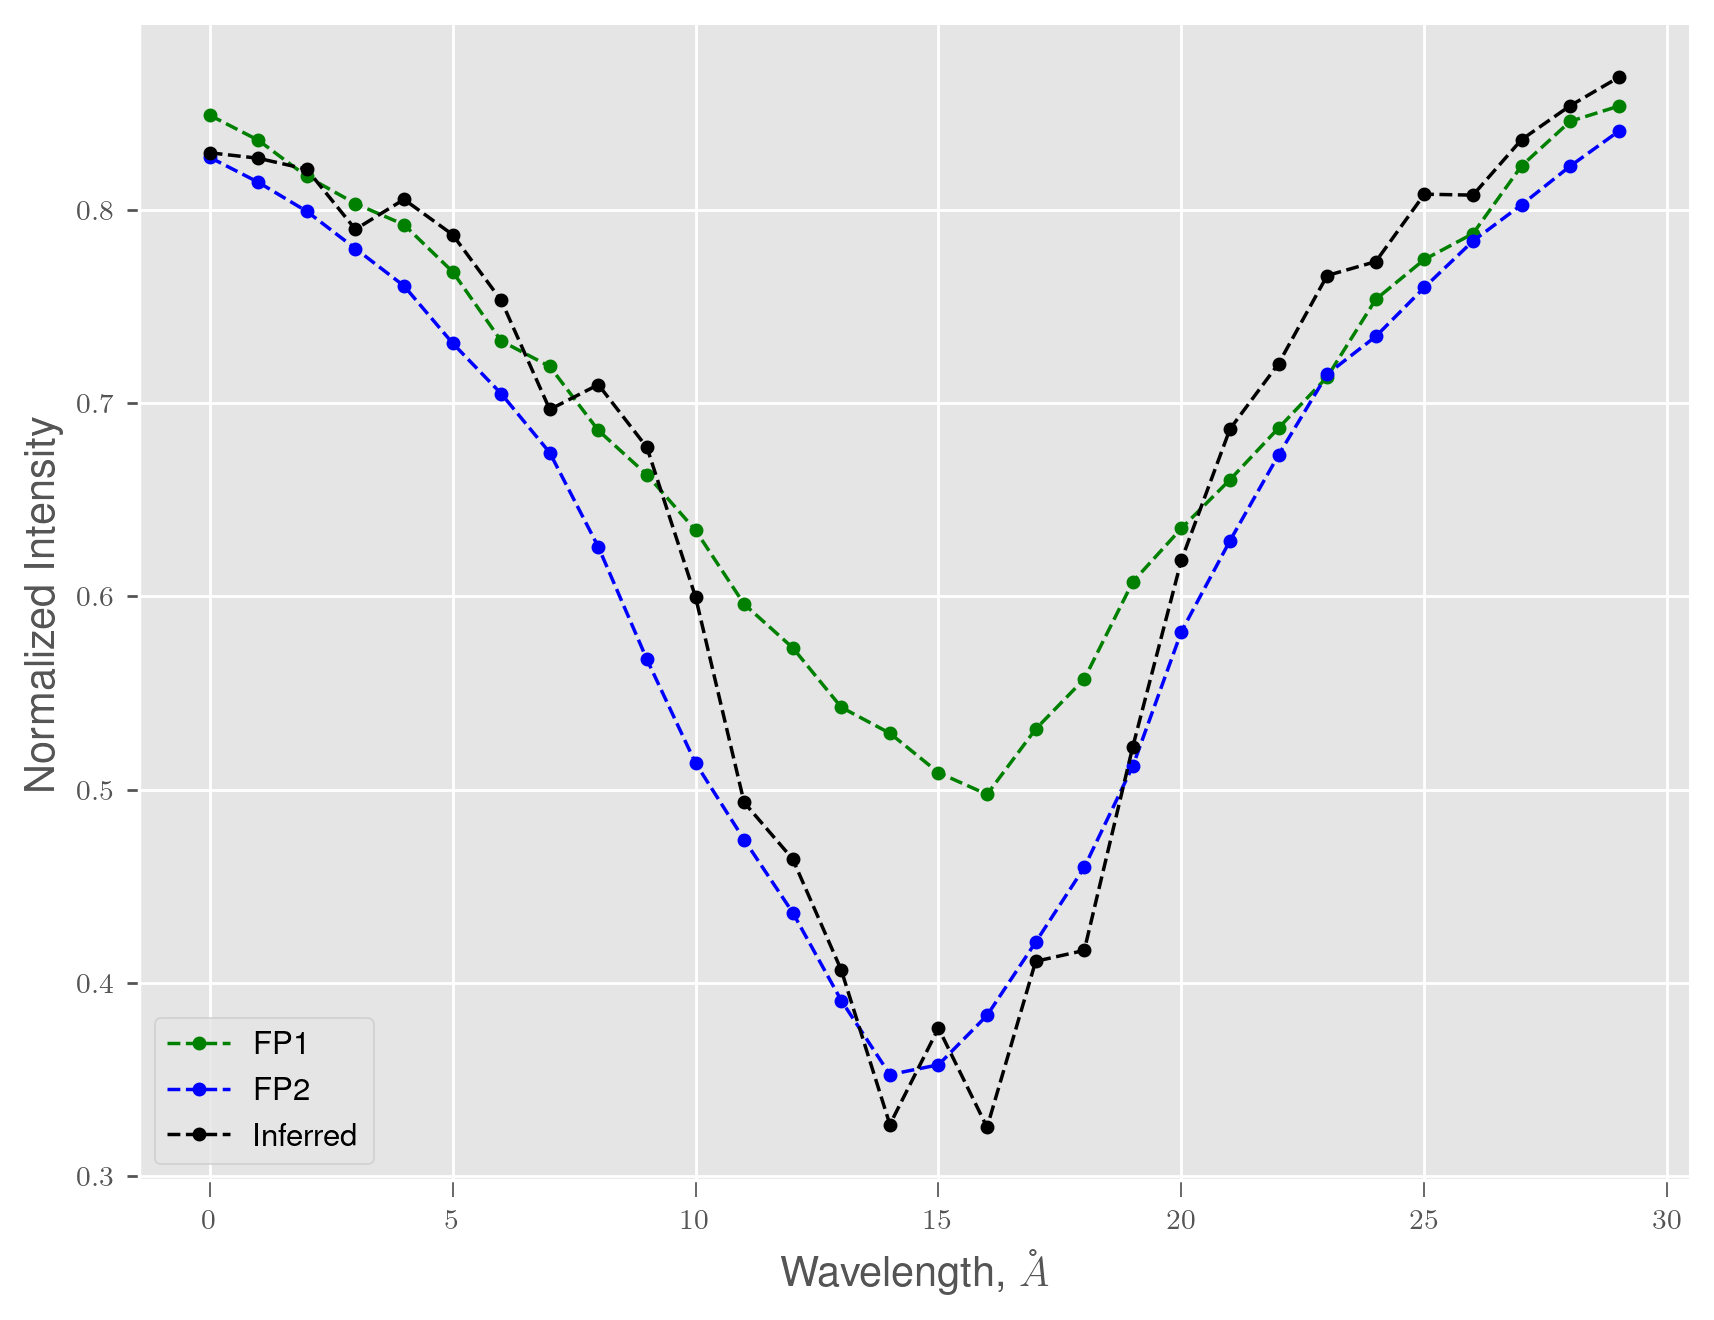

1 FP:-1.017185035393391, 2fp:-0.19456189366449372, recovered:-0.21834656883563142


In [77]:
prevNum  = 200
delta    = 1
wavescale = np.linspace(0, 1, num=dl)

res = model.predict(train_set_modified_ML[prevNum:(prevNum + delta), :, :])

plot_spec_profile_comparison(waves, train_set_modified_ML[prevNum, : , 0],
                             truth_set_modified_ML[prevNum, :], res[0, :])

width_truth = calc_line_width(waves, truth_set_modified_ML[prevNum, :], 12, .5)
width_train = calc_line_width(waves, train_set_modified_ML[prevNum, :, 0], 12, .5)
width_res = calc_line_width(waves, res[0, :], 12, .5)

print(f'1 FP:{width_train}, 2fp:{width_truth}, recovered:{width_res}')

### Compute the intensity scatter plot

7860/7860 [==============================] - 0s 51us/sample


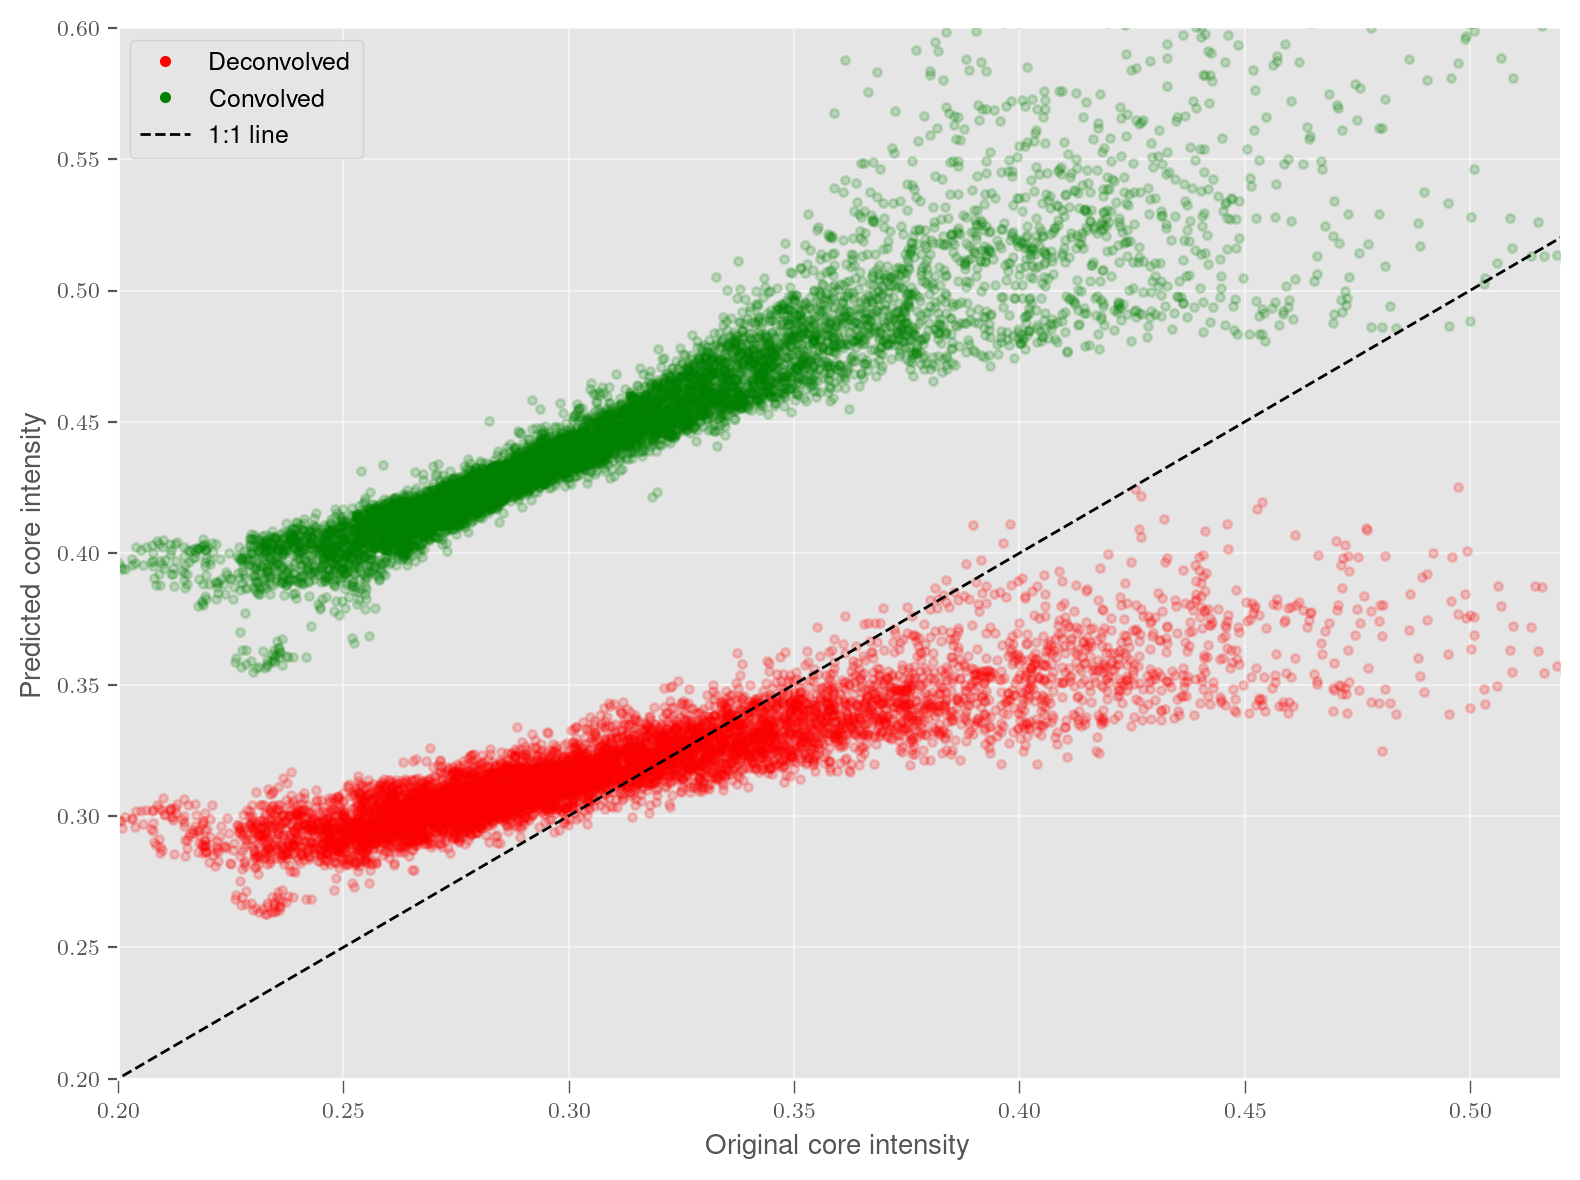

In [78]:
fSizeAxisLabel = 10

wave1_offset = 1
wave2_offset = -1
wave_points_to_fit = 9
alpha1 = 0.18

start = time.process_time()

predict    = model.predict(train_set_modified_ML, verbose=1)


min_I_predict  = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, wave1_offset, wave2_offset,
                                                        wave_points_to_fit) for i in predict)
min_I_truth_ML = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, wave1_offset, wave2_offset,
                                                        wave_points_to_fit) for i
                                    in truth_set_modified_ML)
min_I_train_ML = Parallel(n_jobs=4)(delayed(I_min_find)(waves, i, wave1_offset, wave2_offset,
                                                        wave_points_to_fit) for
                                    i in train_set_modified_ML)

wavex = np.linspace(np.amin(predict)-.05,np.amax(predict),num=1000)


plt.figure(dpi=200,figsize=(8,6))


plt.plot(min_I_truth_ML, min_I_predict, 'r.', alpha=alpha1)
plt.plot(0, 0, 'r.', label='Deconvolved')

plt.plot(min_I_truth_ML, min_I_train_ML, 'g.', alpha=alpha1)
plt.plot(0,0, 'g.', label='Convolved')
plt.plot(wavex,wavex,'k--', label='1:1 line')

# np.savez('Fig3_2.npz', min_I_predict=min_I_predict, min_I_truth_ML=min_I_truth_ML,
#          min_I_train_ML=min_I_train_ML, wavex=wavex)

plt.xlabel('Original core intensity', fontsize = fSizeAxisLabel)
plt.ylabel('Predicted core intensity', fontsize = fSizeAxisLabel)
plt.legend()
plt.xlim(.2, .52)
plt.ylim(0.2, .6)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()



### Compute the width scatter plot

In [74]:
wavex = np.linspace(0,200,num=1000)
waves = np.linspace(0, 29, num=30)

width_wave_offset   = 12
width_height_offset = .5

plt.figure(dpi=200,figsize=(6,4.5))

width_predict  = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, width_wave_offset,
                                                             width_height_offset) for i in predict)
width_truth_ML = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, width_wave_offset,
                                                             width_height_offset) 
                                    for i in truth_set_modified_ML)
width_train_ML = Parallel(n_jobs=4)(delayed(calc_line_width)(waves, i, width_wave_offset,
                                                             width_height_offset) 
                                    for i in train_set_modified_ML[:, :, 0])

plt.plot(width_truth_ML, width_train_ML, 'r.', alpha=0.042)
plt.plot(0, 0, 'r.', label='Convolved')

plt.plot(width_truth_ML, width_predict, 'g.', alpha=0.042)
plt.plot(0, 0, 'g.', label='Deconvolved')


plt.plot(wavex, wavex, 'k--', label='1:1 line')

    
plt.xlabel('Original line witdh [x.05 $\AA$]', fontsize = fSizeAxisLabel)
plt.ylabel('Predicted line width[x.05 $\AA$}]', fontsize = fSizeAxisLabel)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

plt.ylim(5, 25)
plt.xlim(5, 25)
plt.show()




RuntimeError: latex was not able to process the following string:
b'Predicted line width[x.05 $\\\\AA$}]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/molnarad/.matplotlib/tex.cache/b5393cefae48ea6b018b8bfc5d9463ed.tex
LaTeX2e <2018-04-01> patch level 5
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file b5393cefae48ea6b018b8bfc5d9463ed.aux.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/local/texlive/2016/texmf-dist/tex/latex/psnfss/ot1phv.fd)

LaTeX Warning: Command \r invalid in math mode on input line 14.

! Too many }'s.
l.14 ...ffamily Predicted line width[x.05 $\AA$}]}
                                                  
No pages of output.
Transcript written on b5393cefae48ea6b018b8bfc5d9463ed.log.




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


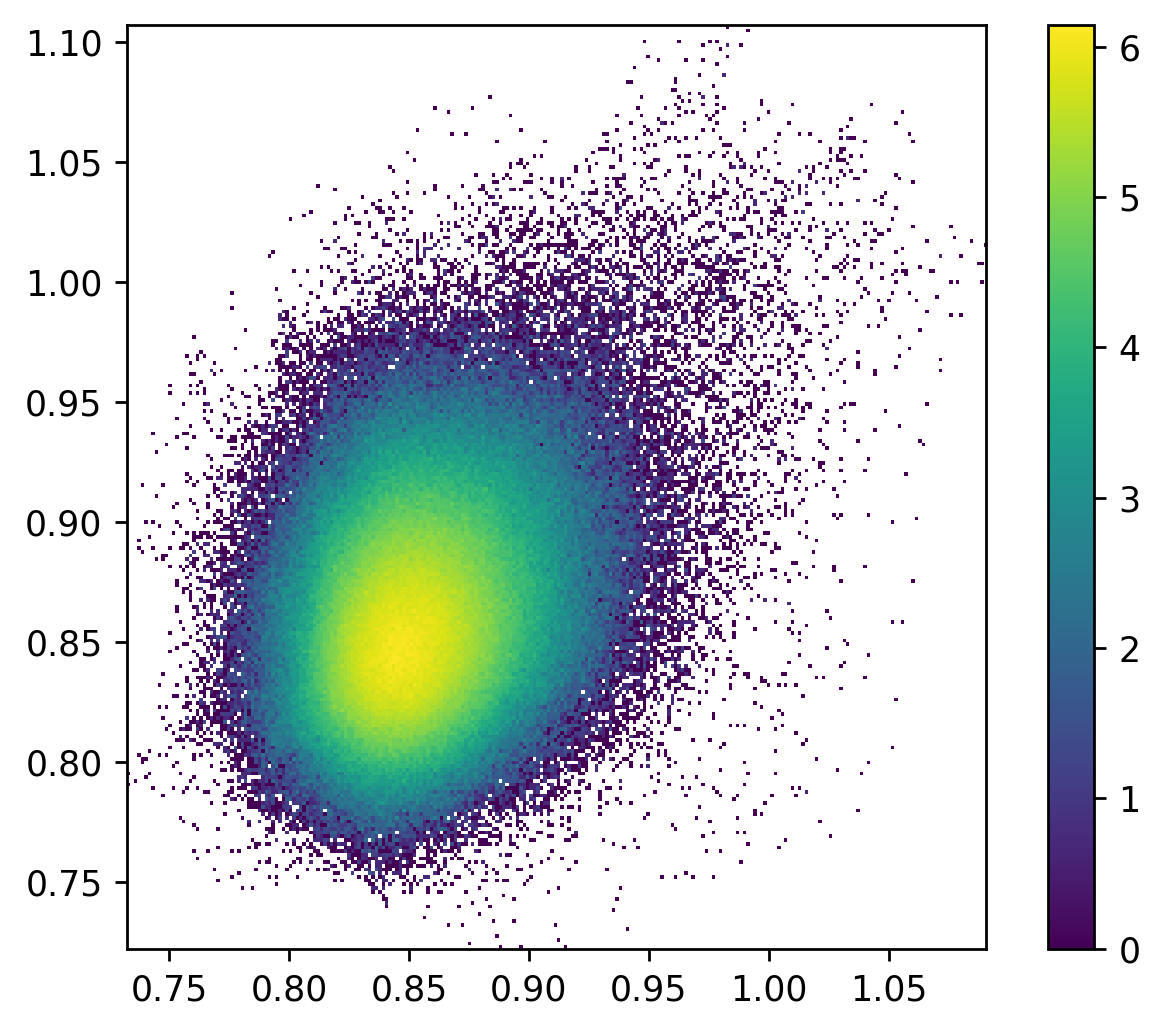

In [380]:
index = -2
plt.figure(dpi=250)
H, xedges, yedges = np.histogram2d(train_set1[:, index], truth_set1[:, index], bins=(250, 250))

H = H.T
im1 = plt.imshow(np.log(H), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           interpolation='nearest', origin='low')
plt.colorbar(im1)
plt.show()

np.savez('Fig_3_3.npz', H=H, xedges=xedges, yedges=yedges)

cent_wave is 15.0
The dlambdas are 23.0 and 7.0
I_red and I_blue are 0.711944580078125 and 0.7381606698036194
the I blue and red thresholds are 0.5662451791012494 and0.5793532239639966


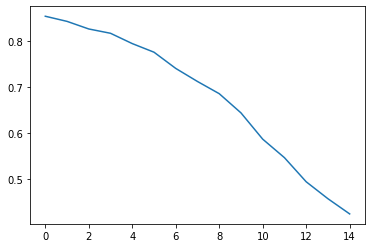

The bisector are blue: 10.521958846671804 and  red:19.40070574884038
The width is 8.878746902168576


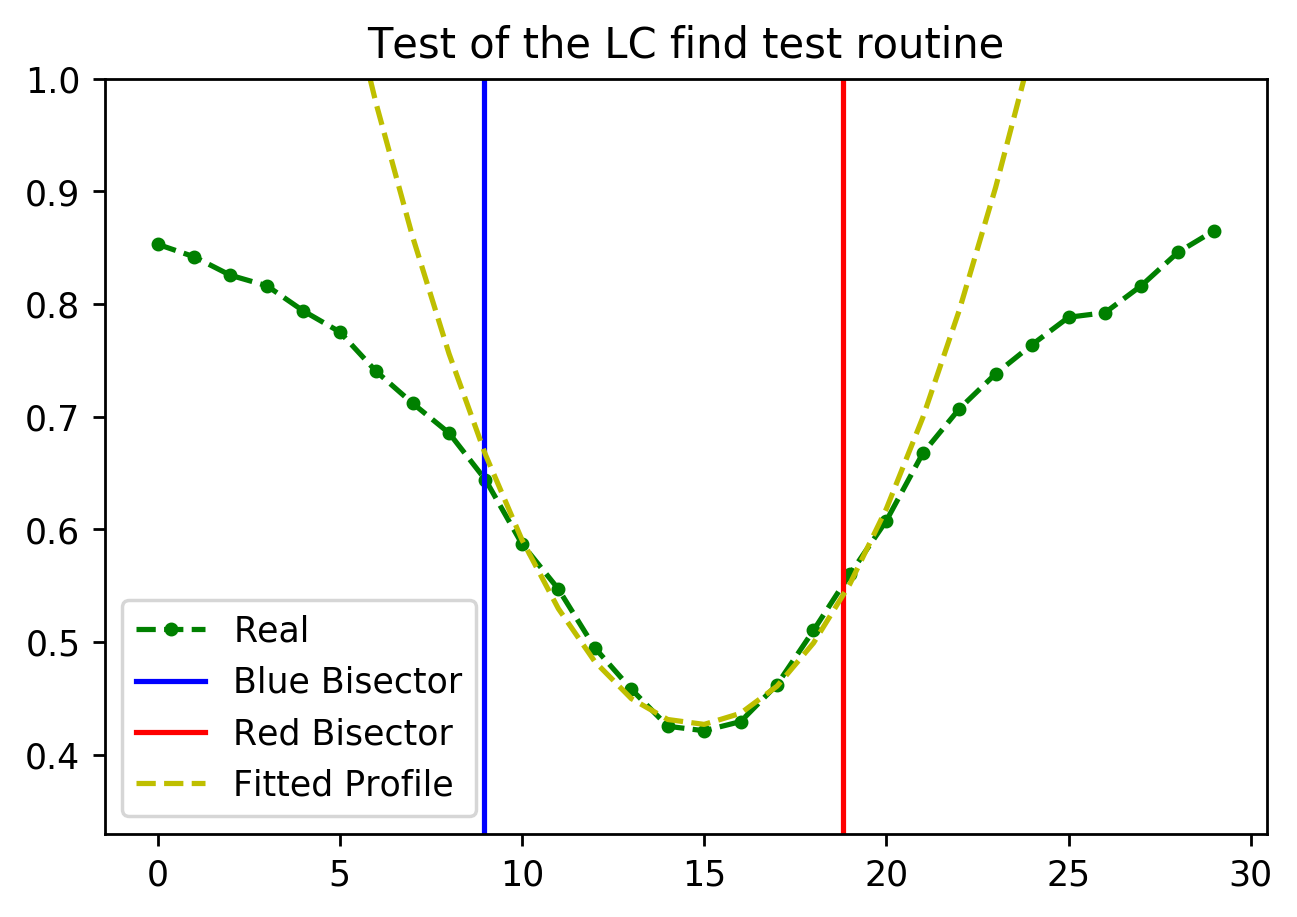

In [10]:
test_index = 10000

def parabola(waves, coeff):
    return [(coeff[0]*i**2 + coeff[1]*i + coeff[2]) for i in waves]

waves = np.linspace(0, 29, num=30)
coeff = lc_find(waves, train_set1[test_index], 2, -2, 9)

line_y = np.linspace(.2, 1, num=100)

width = calc_line_width(waves, train_set1[test_index], 8, .5)
print(f'The width is {width}')
plt.figure(dpi=250)
plt.plot(waves, train_set1[test_index], 'g.--', label='Real')
plt.plot(np.linspace(8.95, 8.95, num=100), line_y, 'b-', label='Blue Bisector')
plt.plot(np.linspace(18.8, 18.8, num=100), line_y, 'r-', label='Red Bisector')
plt.plot(waves, parabola(waves, coeff), 'y--', label='Fitted Profile')
plt.legend()
plt.ylim(0.33, 1)
plt.title('Test of the LC find test routine')
plt.show()

In [297]:
def calc_line_width(wave, Ic, offset, I_threshold):
    '''
    Compute the line width with bisector width following Cauzzi et al. (2009)
    ApJ and the IDL code in lc_find, calc_line_width.pro

    Parameters
    ----------
    wave   : wavelength grid
    Ic     : Intensity grid
    offset : offset for the bisector, given in units as the wave input
    I_threshold : What percentage of the intensity difference between center and
    the bisector to use for measurement of the width

    Returns
    -------
    width : width of the line measured in units of <wave> array, float

    '''

    # Find line center
    try:
        I_min = I_min_find(wave, Ic, 2, -2, 7)
        I_diff = np.abs(Ic - I_min)
        cent_index = I_diff.argmin()
        cent_wave = wave[cent_index]

        dlambda_blue = cent_wave - offset
        dlambda_red = cent_wave + offset
        # Find the wavelength points at half intensity <- Interpolate I in
        # wavelength and then search for them?

        I_blue = np.interp(dlambda_blue, wave, Ic)
        I_red = np.interp(dlambda_red, wave, Ic)
        from scipy import interpolate

        I1 = interpolate.interp1d(Ic[0:cent_index], wave[0:cent_index])
        I2 = interpolate.interp1d(Ic[cent_index:-1], wave[cent_index:-1])
        
        bisector_red  = I2(I_threshold * (I_red - I_min) + I_min)
        bisector_blue = I1(I_threshold * (I_blue - I_min) + I_min)
        #bisector_blue = np.interp((I_threshold * (I_blue - I_min))
        #                          + I_min, np.flipud(Ic[0:cent_index]),
        #                          np.flipud(wave[0:cent_index]))
        #
        #bisector_red = np.interp(I_threshold * (I_red - I_min)
        #                         + I_min, Ic[cent_index:-1],
        #                         wave[cent_index:-1])

        width = bisector_red - bisector_blue

        return width

    except ValueError:

        return float('Nan')

In [158]:
truth_set1.shape

(840224, 30)